In [1]:
# %load data_divide.py
import random
import numpy as np
from tqdm import trange


fold=10
dr_pre=np.loadtxt("./source_data/mat_drug_protein.txt")
simdr=np.loadtxt("./source_data/Similarity_Matrix_Drugs.txt")
simpre=np.loadtxt("./source_data/Similarity_Matrix_Proteins.txt")

prenum=len(simpre)

dd_dim1=dr_pre.flatten()

i=0
list_1=[]
while i<len(dd_dim1):
    if dd_dim1[i]==1:
        list_1.append(i)
    i=i+1
num1=len(list_1)
group_size1=int(num1/fold)
random.seed(10)
random.shuffle(list_1)
#
array_1=np.array(list_1)[0:fold*group_size1]
group_data1=np.reshape(array_1,(fold,group_size1))
np.savetxt("./dataset/index_1.txt",group_data1)


i=0
list_0=[]
while i<len(dd_dim1):
    if dd_dim1[i]==0:
        list_0.append(i)
    i=i+1
num0=len(list_0)
group_size0=int(num0/fold)
random.seed(10)
random.shuffle(list_0)

array_0=np.array(list_0)[0:fold*group_size0]
group_data0=np.reshape(array_0,(fold,group_size0))
np.savetxt("./dataset/index_0.txt",group_data0)


f = 0
for f in trange(fold):
    DTI = np.copy(dr_pre)
    i=0
    while i < group_size1:
        r = int(group_data1[f, i] / prenum)
        c = int(group_data1[f, i] % prenum)
        DTI[r, c] = 0
        i += 1  # 得到每次交叉验证中所使用的A矩阵
    np.savetxt("./dataset/DTI"+str(f)+".txt",DTI)





100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.41it/s]


In [93]:
import numpy as np
np.array(dd_dim1).shape

(1070496,)

# AVE

In [9]:
import numpy as np
from function import *  # 确保这个模块包含所需的函数
from tqdm import trange
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.metrics
import copy
import time
rs = 0.6
n_fold=10
eta=0.7
l_1=5
l_2=5
fr=500
fp=300
K=20
#dr_dis=np.loadtxt("./source_data/luo_simmat_drugs_disease.txt")
dr_pre=np.loadtxt("./source_data/mat_drug_protein.txt")
#pre_dis=np.loadtxt("./source_data/luo_simmat_proteins_disease.txt")
#dr_dr=np.loadtxt("./source_data/luo_simmat_drugs_ddi.txt")
#dr_se=np.loadtxt("./source_data/luo_simmat_drugs_se.txt")
#pre_pre=np.loadtxt("./source_data/luo_simmat_proteins_ppi.txt")
#pre_pre_sw=np.loadtxt("./source_data/luo_simmat_proteins_sw-n.txt")
simdr=np.loadtxt("./source_data/Similarity_Matrix_Drugs.txt")
simpre=np.loadtxt("./source_data/Similarity_Matrix_Proteins.txt")


drnum=len(simdr)     #药物的数目
#disnum=len(dr_dis[0])     #副作用的数目
prenum=len(simpre)     #蛋白质的数目


index_1 = np.loadtxt("./dataset/index_1.txt")
index_0 = np.loadtxt("./dataset/index_0.txt")
index = np.hstack((index_1, index_0))     #水平拼接
reala=dr_pre
sr = simdr
sd = simpre/100

RR=np.zeros(dr_pre.shape)       #原始的邻接矩阵
#A = np.hstack((dr_dr, dr_dis, dr_se))       #Fr
#B = np.hstack((pre_pre, pre_dis))         #Fp
#cutdr_dis = SVD(A, fr)    #奇异值分解    Fr'
#cutpre_dis = SVD(B, fp)     #奇异值分解    Fp'
#pre_simdti = cosine_similarity(cutpre_dis, cutpre_dis)    #计算余弦相似度   SrF
#dr_simdti = cosine_similarity(cutdr_dis, cutdr_dis)        #计算余弦相似度   SpF
S1 = np.loadtxt("./source_data/luo/Dsim/luo_simmat_drugs_ddi.txt")
S2 = np.loadtxt("./source_data/luo/Dsim/luo_simmat_drugs_disease.txt")
S3 = np.loadtxt("./source_data/luo/Dsim/luo_simmat_drugs_se.txt")
S4 = np.loadtxt("./source_data/luo/Dsim/luo_simmat_drugs_tanimoto.txt")
S2_p = np.loadtxt("./source_data/luo/Tsim/luo_simmat_proteins_disease.txt")
S1_p = np.loadtxt("./source_data/luo/Tsim/luo_simmat_proteins_ppi.txt")
S3_p = np.loadtxt("./source_data/luo/Tsim/luo_simmat_proteins_sw-n.txt")


pre_simdti = (1/3) * (S2_p+S1_p+S3_p)
dr_simdti = (1/3) * (S1+S2+S3)

# 记录开始时间
start_time = time.time()

srfp, spfp = pruning(K=K, drug_mat=dr_simdti, target_mat=pre_simdti, miu=eta)
srsp, spsp = pruning(K=K, drug_mat=sr, target_mat=sd, miu=eta)

for f in trange(n_fold):
    a = np.loadtxt("./dataset/DTI" + str(f) + ".txt")
    idx=index[f,:]
   
    R = copy.deepcopy(a)
    R = BiRW(R, dr_simdti, pre_simdti, a, rs)        
    for i in trange(l_1):
        R=BiRW(R, srfp, spfp, a, rs/2)
    for i in trange(l_2):
        R=BiRW(R, srsp, spsp, a, rs/2)

    realvalue=np.zeros(R.shape)
    for i in range(len(idx)):
        d=int(idx[i]/prenum)
        p=int(idx[i]%prenum)
        realvalue[d,p]=reala[d,p]
    for i in range(len(idx)):
        d=int(idx[i]/prenum)
        p=int(idx[i]%prenum)
        RR[d,p]=R[d,p]

y_true_m = dr_pre.tolist()
y_pre_m = RR.tolist()

tpr_cov=[[] for i in range(n_fold)]
fpr_cov=[[] for i in range(n_fold)]
recall_cov=[[] for i in range(n_fold)]
precision_cov=[[] for i in range(n_fold)]

for f in range(n_fold):
    idx=index[f,:]
    singal=[[] for i in range(len(y_true_m))]
    singal_test=[[] for i in range(len(y_true_m))]
    for i in trange(len(y_true_m)):
        for j in range(len(y_true_m[0])):
            if i*prenum+j in idx:
                singal[i].append(y_true_m[i][j])
                singal_test[i].append(y_pre_m[i][j])
    y_true=singal
    y_pre=singal_test

    idx = []
    tpr_list = []
    fpr_list = []
    recall_list = []
    precision_list = []
    c = 0
    for i in trange(len(y_true)):
        if np.sum(np.array(y_true[i])) == 0:
            c += 1
            continue
        else:
            tpr1, fpr1, precision1, recall1 = tpr_fpr_precision_recall(np.array(y_true[i]), np.array(y_pre[i]))
            fpr_list.append(fpr1)
            tpr_list.append(tpr1)
            precision_list.append(precision1)
            recall_list.append(recall1)
    coverage = []

    for i in tpr_list:
        try:
            coverage.append(i.index(1.0)+1)
        except:
            print('1')
    print(np.mean(np.array(coverage)))

    tpr = equal_len_list(tpr_list)
    print(len(tpr ),type(tpr))
    fpr = equal_len_list(fpr_list)
    precision = equal_len_list(precision_list)
    recall = equal_len_list(recall_list)
    tpr_mean = np.mean(tpr, axis=0)
    tpr_cov[f]=tpr_mean
    print(type(tpr_mean),len(tpr_mean))
    fpr_mean = np.mean(fpr, axis=0)
    fpr_cov[f]=fpr_mean
    recall_mean = np.mean(recall, axis=0)
    recall_cov[f]=recall_mean
    precision_mean = np.mean(precision, axis=0)
    precision_cov[f]=precision_mean
    print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean, tpr_mean))
    print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean, precision_mean)+recall_mean[0]*precision_mean[0])

tpr = equal_len_list(tpr_cov)
fpr = equal_len_list(fpr_cov)
precision = equal_len_list(precision_cov)
recall = equal_len_list(recall_cov)

tpr_mean_ave = np.mean(tpr, axis=0)
fpr_mean_ave = np.mean(fpr, axis=0)
recall_mean_ave = np.mean(recall, axis=0)
precision_mean_ave = np.mean(precision, axis=0)

# 计算灵敏度
#sensitivity = tpr_mean_ave  # 由于tpr_mean_ave已经是真正率，这里直接使用

# 记录结束时间并计算运行时间
end_time = time.time()
runtime = end_time - start_time


print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean_ave, tpr_mean_ave))
print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean_ave, precision_mean_ave)+recall_mean_ave[0]*precision_mean_ave[0])

# 打印灵敏度和运行时间
#print('Sensitivity:', sensitivity)
print('Runtime:', runtime)

# 可以选择将灵敏度和运行时间保存到文件中，如果需要
# np.savetxt('./result/sensitivity.txt', sensitivity)
# np.savetxt('./result/runtime.txt', runtime)

# 注意：这里的代码假设tpr_mean_ave已经是计算好的灵敏度值，如果计算方法不同，请相应调整。

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.31s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.40s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.50s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.49s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.51s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.47s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.46s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.46s/it]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1852.59it/s]


7.493333333333333
150 <class 'list'>
<class 'numpy.ndarray'> 131
The auc of prediction is: 0.9630416842011534
The aupr of prediction is: 0.6125996841429198


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1785.78it/s]


7.808219178082192
146 <class 'list'>
<class 'numpy.ndarray'> 116
The auc of prediction is: 0.9595349065898146
The aupr of prediction is: 0.598377834445378


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1713.30it/s]


8.462025316455696
158 <class 'list'>
<class 'numpy.ndarray'> 102
The auc of prediction is: 0.9567635421026012
The aupr of prediction is: 0.5400002035097997


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1730.44it/s]


8.394557823129253
147 <class 'list'>
<class 'numpy.ndarray'> 119
The auc of prediction is: 0.9550237241489945
The aupr of prediction is: 0.5606549259921789


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1863.30it/s]


9.943661971830986
142 <class 'list'>
<class 'numpy.ndarray'> 119
The auc of prediction is: 0.95237049776473
The aupr of prediction is: 0.6389742385656964


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1838.49it/s]


10.973684210526315
152 <class 'list'>
<class 'numpy.ndarray'> 120
The auc of prediction is: 0.944974644342727
The aupr of prediction is: 0.5286344307553269


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1783.50it/s]


11.27891156462585
147 <class 'list'>
<class 'numpy.ndarray'> 126
The auc of prediction is: 0.9392044816103087
The aupr of prediction is: 0.5604342691070668


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1803.32it/s]


8.736486486486486
148 <class 'list'>
<class 'numpy.ndarray'> 128
The auc of prediction is: 0.9574590035447782
The aupr of prediction is: 0.6031145836546494


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1935.68it/s]


7.936619718309859
142 <class 'list'>
<class 'numpy.ndarray'> 127
The auc of prediction is: 0.9585432291361086
The aupr of prediction is: 0.6292687495717


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1913.97it/s]

10.545454545454545
143 <class 'list'>
<class 'numpy.ndarray'> 122
The auc of prediction is: 0.9417340645943751
The aupr of prediction is: 0.5843733888449222
The auc of prediction is: 0.9529000455822059
The aupr of prediction is: 0.5851160342259536
Runtime: 431.49220061302185


In [6]:
# %load run_main.py
import numpy as np
from function import *
from tqdm import trange
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.metrics
import copy
import time
rs = 0.6
n_fold=10
eta=0.7
l_1=5
l_2=5
fr=500
fp=300
K=20
#dr_dis=np.loadtxt("./source_data/luo_simmat_drugs_disease.txt")
dr_pre=np.loadtxt("./source_data/mat_drug_protein.txt")
#pre_dis=np.loadtxt("./source_data/luo_simmat_proteins_disease.txt")
#dr_dr=np.loadtxt("./source_data/luo_simmat_drugs_ddi.txt")
#dr_se=np.loadtxt("./source_data/luo_simmat_drugs_se.txt")
#pre_pre=np.loadtxt("./source_data/luo_simmat_proteins_ppi.txt")
#pre_pre_sw=np.loadtxt("./source_data/luo_simmat_proteins_sw-n.txt")
simdr=np.loadtxt("./source_data/Similarity_Matrix_Drugs.txt")
simpre=np.loadtxt("./source_data/Similarity_Matrix_Proteins.txt")

drnum=len(simdr)     #药物的数目
#disnum=len(dr_dis[0])     #副作用的数目
prenum=len(simpre)     #蛋白质的数目


index_1 = np.loadtxt("./dataset/index_1.txt")
index_0 = np.loadtxt("./dataset/index_0.txt")
index = np.hstack((index_1, index_0))     #水平拼接
reala=dr_pre
sr = simdr
sd = simpre/100

RR=np.zeros(dr_pre.shape)       #原始的邻接矩阵
#A = np.hstack((dr_dr, dr_dis, dr_se))       #Fr
#B = np.hstack((pre_pre, pre_dis))         #Fp
#cutdr_dis = SVD(A, fr)    #奇异值分解    Fr'
#cutpre_dis = SVD(B, fp)     #奇异值分解    Fp'
#pre_simdti = cosine_similarity(cutpre_dis, cutpre_dis)    #计算余弦相似度   SrF
#dr_simdti = cosine_similarity(cutdr_dis, cutdr_dis)        #计算余弦相似度   SpF
S1 = np.loadtxt("./source_data/luo/Dsim/luo_simmat_drugs_ddi.txt")
S2 = np.loadtxt("./source_data/luo/Dsim/luo_simmat_drugs_disease.txt")
S3 = np.loadtxt("./source_data/luo/Dsim/luo_simmat_drugs_se.txt")
S4 = np.loadtxt("./source_data/luo/Dsim/luo_simmat_drugs_tanimoto.txt")
S2_p = np.loadtxt("./source_data/luo/Tsim/luo_simmat_proteins_disease.txt")
S1_p = np.loadtxt("./source_data/luo/Tsim/luo_simmat_proteins_ppi.txt")
S3_p = np.loadtxt("./source_data/luo/Tsim/luo_simmat_proteins_sw-n.txt")

#A = np.hstack((dr_dr, dr_dis, dr_se))       #Fr
#B = np.hstack((pre_pre, pre_dis))         #Fp
#cutdr_dis = SVD(A, fr)    #奇异值分解    Fr'
#cutpre_dis = SVD(B, fp)     #奇异值分解    Fp'
#pre_simdti = cosine_similarity(cutpre_dis, cutpre_dis)    #计算余弦相似度   SrF
#dr_simdti = cosine_similarity(cutdr_dis, cutdr_dis)        #计算余弦相似度   SpF
pre_simdti = (1/3) * (S2_p+S1_p+S3_p)
dr_simdti = (1/3) * (S1+S2+S3)
# 记录开始时间
start_time = time.time()

srfp, spfp = pruning(K=K, drug_mat=dr_simdti, target_mat=pre_simdti, miu=eta)
srsp, spsp = pruning(K=K, drug_mat=sr, target_mat=sd, miu=eta)

for f in trange(n_fold):
    a = np.loadtxt("./dataset/DTI" + str(f) + ".txt")
    idx=index[f,:]
   
    R = copy.deepcopy(a)
    R = BiRW(R, dr_simdti, pre_simdti, a, rs)        
    for i in trange(l_1):
        R=BiRW(R, srfp, spfp, a, rs/2)
    for i in trange(l_2):
        R=BiRW(R, srsp, spsp, a, rs/2)

    realvalue=np.zeros(R.shape)
    for i in range(len(idx)):
        d=int(idx[i]/prenum)
        p=int(idx[i]%prenum)
        realvalue[d,p]=reala[d,p]
    for i in range(len(idx)):
        d=int(idx[i]/prenum)
        p=int(idx[i]%prenum)
        RR[d,p]=R[d,p]

y_true_m = dr_pre.tolist()
y_pre_m = RR.tolist()

tpr_cov=[[] for i in range(n_fold)]
fpr_cov=[[] for i in range(n_fold)]
recall_cov=[[] for i in range(n_fold)]
precision_cov=[[] for i in range(n_fold)]
from sklearn.metrics import f1_score
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests
threshold = 0.5
# F1 Score Calculation
f1_scores = []
for f in range(n_fold):
    f1_fold = []
    for i in range(len(y_true)):
        if np.sum(np.array(y_true[i])) > 0:
            y_true_bin = np.array(y_true[i]).flatten()
            #y_pred_bin = np.array(y_pre[i]).flatten()
            y_pred_bin = (np.array(y_pre[i]) > threshold).astype(int)

            #f1_fold.append(f1_score(y_true_bin, y_pred_bin))
            f1_fold.append(f1_score(y_true_bin, y_pred_bin, average='micro'))

    f1_scores.append(np.mean(f1_fold))
    

mean_f1 = np.mean(f1_scores)
print('Mean F1 Score:', mean_f1)

# Wilcoxon Signed-Rank Test
p_values = []
for metric in [tpr_mean_FGS, fpr_mean_FGS, recall_mean_FGS, precision_mean_FGS]:
    _, p_val = wilcoxon(metric - metric.mean())
    p_values.append(p_val)

# Apply Bergman-Hommel correction
reject, p_adjusted, _, _ = multipletests(p_values, alpha=0.05, method='holm')

print('Wilcoxon Signed-Rank Test Results (Bergman-Hommel corrected):')
print('----------------------------------------------')
print('AUC p-value:', p_adjusted[0], 'Reject Null Hypothesis:', reject[0])
print('AUPR p-value:', p_adjusted[1], 'Reject Null Hypothesis:', reject[1])
print('F1 Score p-value:', p_adjusted[2], 'Reject Null Hypothesis:', reject[2])

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.39s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.80s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.80s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.73s/it]

 50%|█████████████████████████████████████████▌                                         | 5/10 [01:40<01:42, 20.46s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.81s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.75s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.97s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.81s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:26<00:00, 20.64s/it]


Mean F1 Score: 0.9910763805024196
Wilcoxon Signed-Rank Test Results (Bergman-Hommel corrected):
----------------------------------------------
AUC p-value: 0.2330610095464314 Reject Null Hypothesis: False
AUPR p-value: 0.969377458432484 Reject Null Hypothesis: False
F1 Score p-value: 0.2330610095464314 Reject Null Hypothesis: False


In [3]:
# %load run_main.py
import numpy as np
from function import *
from tqdm import trange
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.metrics
import copy
rs = 0.6
n_fold=10
eta=0.7
l_1=5
l_2=5
fr=500
fp=300
K=20
#dr_dis=np.loadtxt("./source_data/luo_simmat_drugs_disease.txt")
dr_pre=np.loadtxt("./source_data/mat_drug_protein.txt")
#pre_dis=np.loadtxt("./source_data/luo_simmat_proteins_disease.txt")
#dr_dr=np.loadtxt("./source_data/luo_simmat_drugs_ddi.txt")
#dr_se=np.loadtxt("./source_data/luo_simmat_drugs_se.txt")
#pre_pre=np.loadtxt("./source_data/luo_simmat_proteins_ppi.txt")
#pre_pre_sw=np.loadtxt("./source_data/luo_simmat_proteins_sw-n.txt")
simdr=np.loadtxt("./source_data/Similarity_Matrix_Drugs.txt")
simpre=np.loadtxt("./source_data/Similarity_Matrix_Proteins.txt")


drnum=len(simdr)     #药物的数目
#disnum=len(dr_dis[0])     #副作用的数目
prenum=len(simpre)     #蛋白质的数目


index_1 = np.loadtxt("./dataset/index_1.txt")
index_0 = np.loadtxt("./dataset/index_0.txt")
index = np.hstack((index_1, index_0))     #水平拼接
reala=dr_pre
sr = simdr
sd = simpre/100

RR=np.zeros(dr_pre.shape)       #原始的邻接矩阵
#A = np.hstack((dr_dr, dr_dis, dr_se))       #Fr
#B = np.hstack((pre_pre, pre_dis))         #Fp
#cutdr_dis = SVD(A, fr)    #奇异值分解    Fr'
#cutpre_dis = SVD(B, fp)     #奇异值分解    Fp'
#pre_simdti = cosine_similarity(cutpre_dis, cutpre_dis)    #计算余弦相似度   SrF
#dr_simdti = cosine_similarity(cutdr_dis, cutdr_dis)        #计算余弦相似度   SpF
S1 = np.loadtxt("./source_data/luo/Dsim/luo_simmat_drugs_ddi.txt")
S2 = np.loadtxt("./source_data/luo/Dsim/luo_simmat_drugs_disease.txt")
S3 = np.loadtxt("./source_data/luo/Dsim/luo_simmat_drugs_se.txt")
S4 = np.loadtxt("./source_data/luo/Dsim/luo_simmat_drugs_tanimoto.txt")
S2_p = np.loadtxt("./source_data/luo/Tsim/luo_simmat_proteins_disease.txt")
S1_p = np.loadtxt("./source_data/luo/Tsim/luo_simmat_proteins_ppi.txt")
S3_p = np.loadtxt("./source_data/luo/Tsim/luo_simmat_proteins_sw-n.txt")


pre_simdti = (1/3) * (S2_p+S1_p+S3_p)
dr_simdti = (1/3) * (S1+S2+S3)


srfp, spfp = pruning(K=K, drug_mat=dr_simdti, target_mat=pre_simdti, miu=eta)
srsp, spsp = pruning(K=K, drug_mat=sr, target_mat=sd, miu=eta)

for f in trange(n_fold):
    a = np.loadtxt("./dataset/DTI" + str(f) + ".txt")
    idx=index[f,:]
   
    R = copy.deepcopy(a)
    R = BiRW(R, dr_simdti, pre_simdti, a, rs)        
    for i in trange(l_1):
        R=BiRW(R, srfp, spfp, a, rs/2)
    for i in trange(l_2):
        R=BiRW(R, srsp, spsp, a, rs/2)

    realvalue=np.zeros(R.shape)
    for i in range(len(idx)):
        d=int(idx[i]/prenum)
        p=int(idx[i]%prenum)
        realvalue[d,p]=reala[d,p]
    for i in range(len(idx)):
        d=int(idx[i]/prenum)
        p=int(idx[i]%prenum)
        RR[d,p]=R[d,p]

y_true_m = dr_pre.tolist()
y_pre_m = R.tolist()

tpr_cov=[[] for i in range(n_fold)]
fpr_cov=[[] for i in range(n_fold)]
recall_cov=[[] for i in range(n_fold)]
precision_cov=[[] for i in range(n_fold)]

for f in range(n_fold):
    idx=index[f,:]
    singal=[[] for i in range(len(y_true_m))]
    singal_test=[[] for i in range(len(y_true_m))]
    for i in trange(len(y_true_m)):
        for j in range(len(y_true_m[0])):
            if i*prenum+j in idx:
                singal[i].append(y_true_m[i][j])
                singal_test[i].append(y_pre_m[i][j])
    y_true=singal
    y_pre=singal_test

    idx = []
    tpr_list = []
    fpr_list = []
    recall_list = []
    precision_list = []
    c = 0
    for i in trange(len(y_true)):
        if np.sum(np.array(y_true[i])) == 0:
            c += 1
            continue
        else:
            tpr1, fpr1, precision1, recall1 = tpr_fpr_precision_recall(np.array(y_true[i]), np.array(y_pre[i]))
            fpr_list.append(fpr1)
            tpr_list.append(tpr1)
            precision_list.append(precision1)
            recall_list.append(recall1)
    coverage = []

    for i in tpr_list:
        try:
            coverage.append(i.index(1.0)+1)
        except:
            print('1')
    print(np.mean(np.array(coverage)))

    tpr = equal_len_list(tpr_list)
    print(len(tpr ),type(tpr))
    fpr = equal_len_list(fpr_list)
    precision = equal_len_list(precision_list)
    recall = equal_len_list(recall_list)
    tpr_mean = np.mean(tpr, axis=0)
    tpr_cov[f]=tpr_mean
    print(type(tpr_mean),len(tpr_mean))
    fpr_mean = np.mean(fpr, axis=0)
    fpr_cov[f]=fpr_mean
    recall_mean = np.mean(recall, axis=0)
    recall_cov[f]=recall_mean
    precision_mean = np.mean(precision, axis=0)
    precision_cov[f]=precision_mean
    print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean, tpr_mean))
    print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean, precision_mean)+recall_mean[0]*precision_mean[0])

tpr = equal_len_list(tpr_cov)
fpr = equal_len_list(fpr_cov)
precision = equal_len_list(precision_cov)
recall = equal_len_list(recall_cov)

tpr_mean_ave = np.mean(tpr, axis=0)
fpr_mean_ave = np.mean(fpr, axis=0)
recall_mean_ave = np.mean(recall, axis=0)
precision_mean_ave = np.mean(precision, axis=0)

print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean_ave, tpr_mean_ave))
print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean_ave, precision_mean_ave)+recall_mean_ave[0]*precision_mean_ave[0])

#np.savetxt('./result/fpr_list_ave.txt', fpr_mean_ave)
#np.savetxt('./result/tpr_list_ave.txt', tpr_mean_ave)
#np.savetxt('./result/recall_list_ave.txt', recall_mean_ave)
#np.savetxt('./result/precision_list_ave.txt', precision_mean_ave)






100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.47s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.11s/it]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1871.29it/s]


1.28
150 <class 'list'>
<class 'numpy.ndarray'> 131
The auc of prediction is: 0.9995164230316602
The aupr of prediction is: 0.9715570502645503


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2034.72it/s]


1.3150684931506849
146 <class 'list'>
<class 'numpy.ndarray'> 116
The auc of prediction is: 0.9994210565654942
The aupr of prediction is: 0.9655270884155877


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1912.23it/s]


1.2151898734177216
158 <class 'list'>
<class 'numpy.ndarray'> 102
The auc of prediction is: 0.9996474436627204
The aupr of prediction is: 0.9770337341327067


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2056.57it/s]


1.3061224489795917
147 <class 'list'>
<class 'numpy.ndarray'> 119
The auc of prediction is: 0.9994777682286748
The aupr of prediction is: 0.9670147083776821


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2089.04it/s]


1.352112676056338
142 <class 'list'>
<class 'numpy.ndarray'> 119
The auc of prediction is: 0.999442435846473
The aupr of prediction is: 0.9651305820053341


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1949.47it/s]


1.263157894736842
152 <class 'list'>
<class 'numpy.ndarray'> 120
The auc of prediction is: 0.999549248375704
The aupr of prediction is: 0.9720503733291562


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2052.52it/s]


1.3061224489795917
147 <class 'list'>
<class 'numpy.ndarray'> 126
The auc of prediction is: 0.9995032036503103
The aupr of prediction is: 0.9688387554568312


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1992.12it/s]


1.2972972972972974
148 <class 'list'>
<class 'numpy.ndarray'> 128
The auc of prediction is: 0.9995062860123074
The aupr of prediction is: 0.9687277247686876


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2339.05it/s]


1.352112676056338
142 <class 'list'>
<class 'numpy.ndarray'> 127
The auc of prediction is: 0.9994618042966972
The aupr of prediction is: 0.965135369139721


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2003.32it/s]

10.545454545454545
143 <class 'list'>
<class 'numpy.ndarray'> 122
The auc of prediction is: 0.9417340645943751
The aupr of prediction is: 0.5843733888449222
The auc of prediction is: 0.9936746082147416
The aupr of prediction is: 0.9254144422112633


# origine

In [1]:
# %load run_main.py
import numpy as np
from function import *
from tqdm import trange
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.metrics
import copy
rs = 0.6
n_fold=10
eta=0.7
l_1=5
l_2=5
fr=500
fp=300
K=20
dr_dis=np.loadtxt("./source_data/mat_drug_disease.txt")
dr_pre=np.loadtxt("./source_data/mat_drug_protein.txt")
pre_dis=np.loadtxt("./source_data/mat_protein_disease.txt")
dr_dr=np.loadtxt("./source_data/mat_drug_drug.txt")
dr_se=np.loadtxt("./source_data/mat_drug_se.txt")
pre_pre=np.loadtxt("./source_data/mat_protein_protein.txt")

simdr=np.loadtxt("./source_data/Similarity_Matrix_Drugs.txt")
simpre=np.loadtxt("./source_data/Similarity_Matrix_Proteins.txt")

drnum=len(dr_dis)     #药物的数目
disnum=len(dr_dis[0])     #副作用的数目
prenum=len(pre_dis)     #蛋白质的数目


index_1 = np.loadtxt("./dataset/index_1.txt")
index_0 = np.loadtxt("./dataset/index_0.txt")
index = np.hstack((index_1, index_0))     #水平拼接
reala=dr_pre
sr = simdr
sd = simpre/100

RR=np.zeros(dr_pre.shape)       #原始的邻接矩阵
A = np.hstack((dr_dr, dr_dis, dr_se))       #Fr
B = np.hstack((pre_pre, pre_dis))         #Fp
cutdr_dis = SVD(A, fr)    #奇异值分解    Fr'
cutpre_dis = SVD(B, fp)     #奇异值分解    Fp'
pre_simdti = cosine_similarity(cutpre_dis, cutpre_dis)    #计算余弦相似度   SrF
dr_simdti = cosine_similarity(cutdr_dis, cutdr_dis)        #计算余弦相似度   SpF



srfp, spfp = pruning(K=K, drug_mat=dr_simdti, target_mat=pre_simdti, miu=eta)
srsp, spsp = pruning(K=K, drug_mat=sr, target_mat=sd, miu=eta)

for f in trange(n_fold):
    a = np.loadtxt("./dataset/DTI" + str(f) + ".txt")
    idx=index[f,:]
   
    R = copy.deepcopy(a)
    R = BiRW(R, dr_simdti, pre_simdti, a, rs)        
    for i in trange(l_1):
        R=BiRW(R, srfp, spfp, a, rs/2)
    #for i in trange(l_2):
        #R=BiRW(R, srsp, spsp, a, rs/2)

    realvalue=np.zeros(R.shape)
    for i in range(len(idx)):
        d=int(idx[i]/prenum)
        p=int(idx[i]%prenum)
        realvalue[d,p]=reala[d,p]
    for i in range(len(idx)):
        d=int(idx[i]/prenum)
        p=int(idx[i]%prenum)
        RR[d,p]=R[d,p]

y_true_m = dr_pre.tolist()
y_pre_m = RR.tolist()

tpr_cov=[[] for i in range(n_fold)]
fpr_cov=[[] for i in range(n_fold)]
recall_cov=[[] for i in range(n_fold)]
precision_cov=[[] for i in range(n_fold)]

for f in range(n_fold):
    idx=index[f,:]
    singal=[[] for i in range(len(y_true_m))]
    singal_test=[[] for i in range(len(y_true_m))]
    for i in trange(len(y_true_m)):
        for j in range(len(y_true_m[0])):
            if i*prenum+j in idx:
                singal[i].append(y_true_m[i][j])
                singal_test[i].append(y_pre_m[i][j])
    y_true=singal
    y_pre=singal_test

    idx = []
    tpr_list = []
    fpr_list = []
    recall_list = []
    precision_list = []
    c = 0
    for i in trange(len(y_true)):
        if np.sum(np.array(y_true[i])) == 0:
            c += 1
            continue
        else:
            tpr1, fpr1, precision1, recall1 = tpr_fpr_precision_recall(np.array(y_true[i]), np.array(y_pre[i]))
            fpr_list.append(fpr1)
            tpr_list.append(tpr1)
            precision_list.append(precision1)
            recall_list.append(recall1)
    coverage = []

    for i in tpr_list:
        try:
            coverage.append(i.index(1.0)+1)
        except:
            print('1')
    print(np.mean(np.array(coverage)))

    tpr = equal_len_list(tpr_list)
    print(len(tpr ),type(tpr))
    fpr = equal_len_list(fpr_list)
    precision = equal_len_list(precision_list)
    recall = equal_len_list(recall_list)
    tpr_mean = np.mean(tpr, axis=0)
    tpr_cov[f]=tpr_mean
    print(type(tpr_mean),len(tpr_mean))
    fpr_mean = np.mean(fpr, axis=0)
    fpr_cov[f]=fpr_mean
    recall_mean = np.mean(recall, axis=0)
    recall_cov[f]=recall_mean
    precision_mean = np.mean(precision, axis=0)
    precision_cov[f]=precision_mean
    print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean, tpr_mean))
    print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean, precision_mean)+recall_mean[0]*precision_mean[0])

tpr = equal_len_list(tpr_cov)
fpr = equal_len_list(fpr_cov)
precision = equal_len_list(precision_cov)
recall = equal_len_list(recall_cov)

tpr_mean = np.mean(tpr, axis=0)
fpr_mean = np.mean(fpr, axis=0)
recall_mean = np.mean(recall, axis=0)
precision_mean = np.mean(precision, axis=0)

print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean, tpr_mean))
print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean, precision_mean)+recall_mean[0]*precision_mean[0])

np.savetxt('./result/fpr_list.txt', fpr_mean)
np.savetxt('./result/tpr_list.txt', tpr_mean)
np.savetxt('./result/recall_list.txt', recall_mean)
np.savetxt('./result/precision_list.txt', precision_mean)






100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2429.49it/s]


9.626666666666667
150 <class 'list'>
<class 'numpy.ndarray'> 131
The auc of prediction is: 0.9511132593263675
The aupr of prediction is: 0.4250047571034047


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2507.64it/s]


10.41095890410959
146 <class 'list'>
<class 'numpy.ndarray'> 116
The auc of prediction is: 0.9456170292037172
The aupr of prediction is: 0.4454923181797197


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2344.83it/s]


10.310126582278482
158 <class 'list'>
<class 'numpy.ndarray'> 102
The auc of prediction is: 0.9485192915010799
The aupr of prediction is: 0.4152576747433123


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2494.33it/s]


12.285714285714286
147 <class 'list'>
<class 'numpy.ndarray'> 119
The auc of prediction is: 0.9332662285415675
The aupr of prediction is: 0.3981976911791855


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2529.11it/s]


10.985915492957746
142 <class 'list'>
<class 'numpy.ndarray'> 119
The auc of prediction is: 0.9428378580681674
The aupr of prediction is: 0.43280544653644504


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2399.84it/s]


13.56578947368421
152 <class 'list'>
<class 'numpy.ndarray'> 120
The auc of prediction is: 0.9235263679468104
The aupr of prediction is: 0.38834325173236883


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2416.79it/s]


13.585034013605442
147 <class 'list'>
<class 'numpy.ndarray'> 126
The auc of prediction is: 0.9232245029724856
The aupr of prediction is: 0.38764078766376464


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2381.00it/s]


9.722972972972974
148 <class 'list'>
<class 'numpy.ndarray'> 128
The auc of prediction is: 0.950581486194576
The aupr of prediction is: 0.4263087093752459


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2079.12it/s]


10.922535211267606
142 <class 'list'>
<class 'numpy.ndarray'> 127
The auc of prediction is: 0.9407925437184601
The aupr of prediction is: 0.44611301164097417


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2493.75it/s]

13.692307692307692
143 <class 'list'>
<class 'numpy.ndarray'> 122
The auc of prediction is: 0.9227500526910047
The aupr of prediction is: 0.4145972042943977
The auc of prediction is: 0.9382617246231271
The aupr of prediction is: 0.4179541447888778


## KA

In [2]:
# %load run_main.py
import numpy as np
from function import *
from tqdm import trange
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.metrics
import copy
import time
rs = 0.6
n_fold=10
eta=0.7
l_1=5
l_2=5
fr=500
fp=300
K=20
#dr_dis=np.loadtxt("./source_data/luo_simmat_drugs_disease.txt")
dr_pre=np.loadtxt("./source_data/mat_drug_protein.txt")
#pre_dis=np.loadtxt("./source_data/luo_simmat_proteins_disease.txt")
#dr_dr=np.loadtxt("./source_data/luo_simmat_drugs_ddi.txt")
#dr_se=np.loadtxt("./source_data/luo_simmat_drugs_se.txt")
#pre_pre=np.loadtxt("./source_data/luo_simmat_proteins_ppi.txt")
#pre_pre_sw=np.loadtxt("./source_data/luo_simmat_proteins_sw-n.txt")
simdr=np.loadtxt("./source_data/Similarity_Matrix_Drugs.txt")
simpre=np.loadtxt("./source_data/Similarity_Matrix_Proteins.txt")

drnum=len(simdr)     #药物的数目
#disnum=len(dr_dis[0])     #副作用的数目
prenum=len(simpre)     #蛋白质的数目


index_1 = np.loadtxt("./dataset/index_1.txt")
index_0 = np.loadtxt("./dataset/index_0.txt")
index = np.hstack((index_1, index_0))     #水平拼接
reala=dr_pre
sr = simdr
sd = simpre/100

RR=np.zeros(dr_pre.shape)       #原始的邻接矩阵
#A = np.hstack((dr_dr, dr_dis, dr_se))       #Fr
#B = np.hstack((pre_pre, pre_dis))         #Fp
#cutdr_dis = SVD(A, fr)    #奇异值分解    Fr'
#cutpre_dis = SVD(B, fp)     #奇异值分解    Fp'
#pre_simdti = cosine_similarity(cutpre_dis, cutpre_dis)    #计算余弦相似度   SrF
#dr_simdti = cosine_similarity(cutdr_dis, cutdr_dis)        #计算余弦相似度   SpF
pre_simdti = np.loadtxt("./source_data/S_com_KA_p.txt")
dr_simdti = np.loadtxt("./source_data/S_com_KA_d.txt")

# 记录开始时间
start_time = time.time()

srfp, spfp = pruning(K=K, drug_mat=dr_simdti, target_mat=pre_simdti, miu=eta)
srsp, spsp = pruning(K=K, drug_mat=sr, target_mat=sd, miu=eta)

for f in trange(n_fold):
    a = np.loadtxt("./dataset/DTI" + str(f) + ".txt")
    idx=index[f,:]
   
    R = copy.deepcopy(a)
    R = BiRW(R, dr_simdti, pre_simdti, a, rs)        
    for i in trange(l_1):
        R=BiRW(R, srfp, spfp, a, rs/2)
    for i in trange(l_2):
        R=BiRW(R, srsp, spsp, a, rs/2)

    realvalue=np.zeros(R.shape)
    for i in range(len(idx)):
        d=int(idx[i]/prenum)
        p=int(idx[i]%prenum)
        realvalue[d,p]=reala[d,p]
    for i in range(len(idx)):
        d=int(idx[i]/prenum)
        p=int(idx[i]%prenum)
        RR[d,p]=R[d,p]

y_true_m = dr_pre.tolist()
y_pre_m = RR.tolist()

tpr_cov=[[] for i in range(n_fold)]
fpr_cov=[[] for i in range(n_fold)]
recall_cov=[[] for i in range(n_fold)]
precision_cov=[[] for i in range(n_fold)]

for f in range(n_fold):
    idx=index[f,:]
    singal=[[] for i in range(len(y_true_m))]
    singal_test=[[] for i in range(len(y_true_m))]
    for i in trange(len(y_true_m)):
        for j in range(len(y_true_m[0])):
            if i*prenum+j in idx:
                singal[i].append(y_true_m[i][j])
                singal_test[i].append(y_pre_m[i][j])
    y_true=singal
    y_pre=singal_test

    idx = []
    tpr_list = []
    fpr_list = []
    recall_list = []
    precision_list = []
    c = 0
    for i in trange(len(y_true)):
        if np.sum(np.array(y_true[i])) == 0:
            c += 1
            continue
        else:
            tpr1, fpr1, precision1, recall1 = tpr_fpr_precision_recall(np.array(y_true[i]), np.array(y_pre[i]))
            fpr_list.append(fpr1)
            tpr_list.append(tpr1)
            precision_list.append(precision1)
            recall_list.append(recall1)
    coverage = []

    for i in tpr_list:
        try:
            coverage.append(i.index(1.0)+1)
        except:
            print('1')
    print(np.mean(np.array(coverage)))

    tpr = equal_len_list(tpr_list)
    print(len(tpr ),type(tpr))
    fpr = equal_len_list(fpr_list)
    precision = equal_len_list(precision_list)
    recall = equal_len_list(recall_list)
    tpr_mean = np.mean(tpr, axis=0)
    tpr_cov[f]=tpr_mean
    print(type(tpr_mean),len(tpr_mean))
    fpr_mean = np.mean(fpr, axis=0)
    fpr_cov[f]=fpr_mean
    recall_mean = np.mean(recall, axis=0)
    recall_cov[f]=recall_mean
    precision_mean = np.mean(precision, axis=0)
    precision_cov[f]=precision_mean
    print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean, tpr_mean))
    print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean, precision_mean)+recall_mean[0]*precision_mean[0])

tpr = equal_len_list(tpr_cov)
fpr = equal_len_list(fpr_cov)
precision = equal_len_list(precision_cov)
recall = equal_len_list(recall_cov)

tpr_mean_KA = np.mean(tpr, axis=0)
fpr_mean_KA = np.mean(fpr, axis=0)
recall_mean_KA = np.mean(recall, axis=0)
precision_mean_KA = np.mean(precision, axis=0)

# 记录结束时间并计算运行时间
end_time = time.time()
runtime = end_time - start_time

print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean_KA, tpr_mean_KA))
print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean_KA, precision_mean_KA)+recall_mean_KA[0]*precision_mean_KA[0])
# 打印灵敏度和运行时间
print('Runtime:', runtime)
#np.savetxt('./result/fpr_list_KA.txt', fpr_mean_KA)
#np.savetxt('./result/tpr_list.txt_KA', tpr_mean_KA)
#np.savetxt('./result/recall_list_KA.txt', recall_mean_KA)
#np.savetxt('./result/precision_list_KA.txt', precision_mean_KA)








100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.41s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.67s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.57s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.53s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.58s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.59s/it]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1830.56it/s]


7.446666666666666
150 <class 'list'>
<class 'numpy.ndarray'> 131
The auc of prediction is: 0.9629509375352208
The aupr of prediction is: 0.618105801710723


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1884.92it/s]


7.465753424657534
146 <class 'list'>
<class 'numpy.ndarray'> 116
The auc of prediction is: 0.9616197938801019
The aupr of prediction is: 0.6014292672406503


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1780.63it/s]


8.20253164556962
158 <class 'list'>
<class 'numpy.ndarray'> 102
The auc of prediction is: 0.9577696575255323
The aupr of prediction is: 0.5296951186212839


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1816.32it/s]


7.312925170068027
147 <class 'list'>
<class 'numpy.ndarray'> 119
The auc of prediction is: 0.9621286333536248
The aupr of prediction is: 0.5549861272888488


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2042.25it/s]


10.690140845070422
142 <class 'list'>
<class 'numpy.ndarray'> 119
The auc of prediction is: 0.9479656695757201
The aupr of prediction is: 0.6006662645807576


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1824.31it/s]


11.789473684210526
152 <class 'list'>
<class 'numpy.ndarray'> 120
The auc of prediction is: 0.9396036385146945
The aupr of prediction is: 0.5294749083556437


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1952.03it/s]


10.918367346938776
147 <class 'list'>
<class 'numpy.ndarray'> 126
The auc of prediction is: 0.9411615989629211
The aupr of prediction is: 0.5655620502448002


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2150.14it/s]


8.878378378378379
148 <class 'list'>
<class 'numpy.ndarray'> 128
The auc of prediction is: 0.956215965122639
The aupr of prediction is: 0.5720030368113298


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1908.57it/s]


8.894366197183098
142 <class 'list'>
<class 'numpy.ndarray'> 127
The auc of prediction is: 0.9532174473773276
The aupr of prediction is: 0.6113715238042591


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1944.40it/s]

11.062937062937063
143 <class 'list'>
<class 'numpy.ndarray'> 122
The auc of prediction is: 0.9388471456846911
The aupr of prediction is: 0.5927841561045167
The auc of prediction is: 0.9521431599211453
The aupr of prediction is: 0.5772640403370544
Runtime: 460.6331226825714


In [7]:
# %load run_main.py
import numpy as np
from function import *
from tqdm import trange
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.metrics
import copy
import time
rs = 0.6
n_fold=10
eta=0.7
l_1=5
l_2=5
fr=500
fp=300
K=20
#dr_dis=np.loadtxt("./source_data/luo_simmat_drugs_disease.txt")
dr_pre=np.loadtxt("./source_data/mat_drug_protein.txt")
#pre_dis=np.loadtxt("./source_data/luo_simmat_proteins_disease.txt")
#dr_dr=np.loadtxt("./source_data/luo_simmat_drugs_ddi.txt")
#dr_se=np.loadtxt("./source_data/luo_simmat_drugs_se.txt")
#pre_pre=np.loadtxt("./source_data/luo_simmat_proteins_ppi.txt")
#pre_pre_sw=np.loadtxt("./source_data/luo_simmat_proteins_sw-n.txt")
simdr=np.loadtxt("./source_data/Similarity_Matrix_Drugs.txt")
simpre=np.loadtxt("./source_data/Similarity_Matrix_Proteins.txt")

drnum=len(simdr)     #药物的数目
#disnum=len(dr_dis[0])     #副作用的数目
prenum=len(simpre)     #蛋白质的数目


index_1 = np.loadtxt("./dataset/index_1.txt")
index_0 = np.loadtxt("./dataset/index_0.txt")
index = np.hstack((index_1, index_0))     #水平拼接
reala=dr_pre
sr = simdr
sd = simpre/100

RR=np.zeros(dr_pre.shape)       #原始的邻接矩阵
#A = np.hstack((dr_dr, dr_dis, dr_se))       #Fr
#B = np.hstack((pre_pre, pre_dis))         #Fp
#cutdr_dis = SVD(A, fr)    #奇异值分解    Fr'
#cutpre_dis = SVD(B, fp)     #奇异值分解    Fp'
#pre_simdti = cosine_similarity(cutpre_dis, cutpre_dis)    #计算余弦相似度   SrF
#dr_simdti = cosine_similarity(cutdr_dis, cutdr_dis)        #计算余弦相似度   SpF
pre_simdti = np.loadtxt("./source_data/S_com_KA_p.txt")
dr_simdti = np.loadtxt("./source_data/S_com_KA_d.txt")
# 记录开始时间
start_time = time.time()

srfp, spfp = pruning(K=K, drug_mat=dr_simdti, target_mat=pre_simdti, miu=eta)
srsp, spsp = pruning(K=K, drug_mat=sr, target_mat=sd, miu=eta)

for f in trange(n_fold):
    a = np.loadtxt("./dataset/DTI" + str(f) + ".txt")
    idx=index[f,:]
   
    R = copy.deepcopy(a)
    R = BiRW(R, dr_simdti, pre_simdti, a, rs)        
    for i in trange(l_1):
        R=BiRW(R, srfp, spfp, a, rs/2)
    for i in trange(l_2):
        R=BiRW(R, srsp, spsp, a, rs/2)

    realvalue=np.zeros(R.shape)
    for i in range(len(idx)):
        d=int(idx[i]/prenum)
        p=int(idx[i]%prenum)
        realvalue[d,p]=reala[d,p]
    for i in range(len(idx)):
        d=int(idx[i]/prenum)
        p=int(idx[i]%prenum)
        RR[d,p]=R[d,p]

y_true_m = dr_pre.tolist()
y_pre_m = RR.tolist()

tpr_cov=[[] for i in range(n_fold)]
fpr_cov=[[] for i in range(n_fold)]
recall_cov=[[] for i in range(n_fold)]
precision_cov=[[] for i in range(n_fold)]
from sklearn.metrics import f1_score
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests
threshold = 0.5
# F1 Score Calculation
f1_scores = []
for f in range(n_fold):
    f1_fold = []
    for i in range(len(y_true)):
        if np.sum(np.array(y_true[i])) > 0:
            y_true_bin = np.array(y_true[i]).flatten()
            #y_pred_bin = np.array(y_pre[i]).flatten()
            y_pred_bin = (np.array(y_pre[i]) > threshold).astype(int)

            #f1_fold.append(f1_score(y_true_bin, y_pred_bin))
            f1_fold.append(f1_score(y_true_bin, y_pred_bin, average='micro'))

    f1_scores.append(np.mean(f1_fold))
    

mean_f1 = np.mean(f1_scores)
print('Mean F1 Score:', mean_f1)

# Wilcoxon Signed-Rank Test
p_values = []
for metric in [tpr_mean_FGS, fpr_mean_FGS, recall_mean_FGS, precision_mean_FGS]:
    _, p_val = wilcoxon(metric - metric.mean())
    p_values.append(p_val)

# Apply Bergman-Hommel correction
reject, p_adjusted, _, _ = multipletests(p_values, alpha=0.05, method='holm')

print('Wilcoxon Signed-Rank Test Results (Bergman-Hommel corrected):')
print('----------------------------------------------')
print('AUC p-value:', p_adjusted[0], 'Reject Null Hypothesis:', reject[0])
print('AUPR p-value:', p_adjusted[1], 'Reject Null Hypothesis:', reject[1])
print('F1 Score p-value:', p_adjusted[2], 'Reject Null Hypothesis:', reject[2])

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.33s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.70s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.72s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.66s/it]

 50%|█████████████████████████████████████████▌                                         | 5/10 [01:36<01:37, 19.51s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.72s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.66s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.67s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.76s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.80s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:14<00:00, 19.42s/it]


Mean F1 Score: 0.9910763805024196
Wilcoxon Signed-Rank Test Results (Bergman-Hommel corrected):
----------------------------------------------
AUC p-value: 0.2330610095464314 Reject Null Hypothesis: False
AUPR p-value: 0.969377458432484 Reject Null Hypothesis: False
F1 Score p-value: 0.2330610095464314 Reject Null Hypothesis: False


## HSIC

In [5]:
# %load run_main.py
import numpy as np
from function import *
from tqdm import trange
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.metrics
import copy
import time
rs = 0.6
n_fold=10
eta=0.7
l_1=5
l_2=5
fr=500
fp=300
K=20
#dr_dis=np.loadtxt("./source_data/luo_simmat_drugs_disease.txt")
dr_pre=np.loadtxt("./source_data/mat_drug_protein.txt")
#pre_dis=np.loadtxt("./source_data/luo_simmat_proteins_disease.txt")
#dr_dr=np.loadtxt("./source_data/luo_simmat_drugs_ddi.txt")
#dr_se=np.loadtxt("./source_data/luo_simmat_drugs_se.txt")
#pre_pre=np.loadtxt("./source_data/luo_simmat_proteins_ppi.txt")
#pre_pre_sw=np.loadtxt("./source_data/luo_simmat_proteins_sw-n.txt")
simdr=np.loadtxt("./source_data/Similarity_Matrix_Drugs.txt")
simpre=np.loadtxt("./source_data/Similarity_Matrix_Proteins.txt")

drnum=len(simdr)     #药物的数目
#disnum=len(dr_dis[0])     #副作用的数目
prenum=len(simpre)     #蛋白质的数目


index_1 = np.loadtxt("./dataset/index_1.txt")
index_0 = np.loadtxt("./dataset/index_0.txt")
index = np.hstack((index_1, index_0))     #水平拼接
reala=dr_pre
sr = simdr
sd = simpre/100

RR=np.zeros(dr_pre.shape)       #原始的邻接矩阵
#A = np.hstack((dr_dr, dr_dis, dr_se))       #Fr
#B = np.hstack((pre_pre, pre_dis))         #Fp
#cutdr_dis = SVD(A, fr)    #奇异值分解    Fr'
#cutpre_dis = SVD(B, fp)     #奇异值分解    Fp'
#pre_simdti = cosine_similarity(cutpre_dis, cutpre_dis)    #计算余弦相似度   SrF
#dr_simdti = cosine_similarity(cutdr_dis, cutdr_dis)        #计算余弦相似度   SpF
pre_simdti = np.loadtxt("./source_data/S_com_hsic_p.txt")
dr_simdti = np.loadtxt("./source_data/S_com_hsic_d.txt")

# 记录开始时间
start_time = time.time()

srfp, spfp = pruning(K=K, drug_mat=dr_simdti, target_mat=pre_simdti, miu=eta)
srsp, spsp = pruning(K=K, drug_mat=sr, target_mat=sd, miu=eta)

for f in trange(n_fold):
    a = np.loadtxt("./dataset/DTI" + str(f) + ".txt")
    idx=index[f,:]
   
    R = copy.deepcopy(a)
    R = BiRW(R, dr_simdti, pre_simdti, a, rs)        
    for i in trange(l_1):
        R=BiRW(R, srfp, spfp, a, rs/2)
    for i in trange(l_2):
        R=BiRW(R, srsp, spsp, a, rs/2)

    realvalue=np.zeros(R.shape)
    for i in range(len(idx)):
        d=int(idx[i]/prenum)
        p=int(idx[i]%prenum)
        realvalue[d,p]=reala[d,p]
    for i in range(len(idx)):
        d=int(idx[i]/prenum)
        p=int(idx[i]%prenum)
        RR[d,p]=R[d,p]

y_true_m = dr_pre.tolist()
y_pre_m = RR.tolist()

tpr_cov=[[] for i in range(n_fold)]
fpr_cov=[[] for i in range(n_fold)]
recall_cov=[[] for i in range(n_fold)]
precision_cov=[[] for i in range(n_fold)]

for f in range(n_fold):
    idx=index[f,:]
    singal=[[] for i in range(len(y_true_m))]
    singal_test=[[] for i in range(len(y_true_m))]
    for i in trange(len(y_true_m)):
        for j in range(len(y_true_m[0])):
            if i*prenum+j in idx:
                singal[i].append(y_true_m[i][j])
                singal_test[i].append(y_pre_m[i][j])
    y_true=singal
    y_pre=singal_test

    idx = []
    tpr_list = []
    fpr_list = []
    recall_list = []
    precision_list = []
    c = 0
    for i in trange(len(y_true)):
        if np.sum(np.array(y_true[i])) == 0:
            c += 1
            continue
        else:
            tpr1, fpr1, precision1, recall1 = tpr_fpr_precision_recall(np.array(y_true[i]), np.array(y_pre[i]))
            fpr_list.append(fpr1)
            tpr_list.append(tpr1)
            precision_list.append(precision1)
            recall_list.append(recall1)
    coverage = []

    for i in tpr_list:
        try:
            coverage.append(i.index(1.0)+1)
        except:
            print('1')
    print(np.mean(np.array(coverage)))

    tpr = equal_len_list(tpr_list)
    print(len(tpr ),type(tpr))
    fpr = equal_len_list(fpr_list)
    precision = equal_len_list(precision_list)
    recall = equal_len_list(recall_list)
    tpr_mean = np.mean(tpr, axis=0)
    tpr_cov[f]=tpr_mean
    print(type(tpr_mean),len(tpr_mean))
    fpr_mean = np.mean(fpr, axis=0)
    fpr_cov[f]=fpr_mean
    recall_mean = np.mean(recall, axis=0)
    recall_cov[f]=recall_mean
    precision_mean = np.mean(precision, axis=0)
    precision_cov[f]=precision_mean
    print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean, tpr_mean))
    print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean, precision_mean)+recall_mean[0]*precision_mean[0])

tpr = equal_len_list(tpr_cov)
fpr = equal_len_list(fpr_cov)
precision = equal_len_list(precision_cov)
recall = equal_len_list(recall_cov)

tpr_mean_hsic = np.mean(tpr, axis=0)
fpr_mean_hsic = np.mean(fpr, axis=0)
recall_mean_hsic = np.mean(recall, axis=0)
precision_mean_hsic = np.mean(precision, axis=0)

# 记录结束时间并计算运行时间
end_time = time.time()
runtime = end_time - start_time

print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean_hsic, tpr_mean_hsic))
print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean_hsic, precision_mean_hsic)+recall_mean_hsic[0]*precision_mean_hsic[0])
# 打印灵敏度和运行时间

print('Runtime:', runtime)
#np.savetxt('./result/fpr_list_hsic.txt', fpr_mean_hsic)
#np.savetxt('./result/tpr_list_hsic.txt', tpr_mean_hsic)
#np.savetxt('./result/recall_list_hsic.txt', recall_mean_hsic)
#np.savetxt('./result/precision_list_hsic.txt', precision_mean_hsic)






100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.30s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.51s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.56s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.47s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.50s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.48s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.48s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.48s/it]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1776.49it/s]


7.306666666666667
150 <class 'list'>
<class 'numpy.ndarray'> 131
The auc of prediction is: 0.9641589777211005
The aupr of prediction is: 0.6194849541670802


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1917.95it/s]


8.102739726027398
146 <class 'list'>
<class 'numpy.ndarray'> 116
The auc of prediction is: 0.9576675564238686
The aupr of prediction is: 0.5976840095934248


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1719.24it/s]


8.19620253164557
158 <class 'list'>
<class 'numpy.ndarray'> 102
The auc of prediction is: 0.9581032972967493
The aupr of prediction is: 0.538414798526832


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1856.82it/s]


7.707482993197279
147 <class 'list'>
<class 'numpy.ndarray'> 119
The auc of prediction is: 0.9595124604306525
The aupr of prediction is: 0.5478705737826441


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1814.76it/s]


9.077464788732394
142 <class 'list'>
<class 'numpy.ndarray'> 119
The auc of prediction is: 0.9579944212047317
The aupr of prediction is: 0.6112176970747916


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1727.10it/s]


10.875
152 <class 'list'>
<class 'numpy.ndarray'> 120
The auc of prediction is: 0.9453794582238091
The aupr of prediction is: 0.5298043868784287


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1814.10it/s]


11.020408163265307
147 <class 'list'>
<class 'numpy.ndarray'> 126
The auc of prediction is: 0.9406901815036784
The aupr of prediction is: 0.5551273389956016


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1828.82it/s]


8.756756756756756
148 <class 'list'>
<class 'numpy.ndarray'> 128
The auc of prediction is: 0.95744305694921
The aupr of prediction is: 0.5914832032097663


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1863.11it/s]


7.78169014084507
142 <class 'list'>
<class 'numpy.ndarray'> 127
The auc of prediction is: 0.9596626504477117
The aupr of prediction is: 0.6597783862242237


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1872.79it/s]


10.692307692307692
143 <class 'list'>
<class 'numpy.ndarray'> 122
The auc of prediction is: 0.9406812300811292
The aupr of prediction is: 0.5970190957366903
The auc of prediction is: 0.9540954900818354
The aupr of prediction is: 0.5841500375550464
Runtime: 432.1815142631531


## LIC

In [4]:
# %load run_main.py
import numpy as np
from function import *
from tqdm import trange
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.metrics
import copy
import time
rs = 0.6
n_fold=10
eta=0.7
l_1=5
l_2=5
fr=500
fp=300
K=20
#dr_dis=np.loadtxt("./source_data/luo_simmat_drugs_disease.txt")
dr_pre=np.loadtxt("./source_data/mat_drug_protein.txt")
#pre_dis=np.loadtxt("./source_data/luo_simmat_proteins_disease.txt")
#dr_dr=np.loadtxt("./source_data/luo_simmat_drugs_ddi.txt")
#dr_se=np.loadtxt("./source_data/luo_simmat_drugs_se.txt")
#pre_pre=np.loadtxt("./source_data/luo_simmat_proteins_ppi.txt")
#pre_pre_sw=np.loadtxt("./source_data/luo_simmat_proteins_sw-n.txt")
simdr=np.loadtxt("./source_data/Similarity_Matrix_Drugs.txt")
simpre=np.loadtxt("./source_data/Similarity_Matrix_Proteins.txt")

drnum=len(simdr)     #药物的数目
#disnum=len(dr_dis[0])     #副作用的数目
prenum=len(simpre)     #蛋白质的数目


index_1 = np.loadtxt("./dataset/index_1.txt")
index_0 = np.loadtxt("./dataset/index_0.txt")
index = np.hstack((index_1, index_0))     #水平拼接
reala=dr_pre
sr = simdr
sd = simpre/100

RR=np.zeros(dr_pre.shape)       #原始的邻接矩阵
#A = np.hstack((dr_dr, dr_dis, dr_se))       #Fr
#B = np.hstack((pre_pre, pre_dis))         #Fp
#cutdr_dis = SVD(A, fr)    #奇异值分解    Fr'
#cutpre_dis = SVD(B, fp)     #奇异值分解    Fp'
#pre_simdti = cosine_similarity(cutpre_dis, cutpre_dis)    #计算余弦相似度   SrF
#dr_simdti = cosine_similarity(cutdr_dis, cutdr_dis)        #计算余弦相似度   SpF
pre_simdti = np.loadtxt("./source_data/S_com_lic_p.txt")
dr_simdti = np.loadtxt("./source_data/S_com_lic_d.txt")

# 记录开始时间
start_time = time.time()

srfp, spfp = pruning(K=K, drug_mat=dr_simdti, target_mat=pre_simdti, miu=eta)
srsp, spsp = pruning(K=K, drug_mat=sr, target_mat=sd, miu=eta)

for f in trange(n_fold):
    a = np.loadtxt("./dataset/DTI" + str(f) + ".txt")
    idx=index[f,:]
   
    R = copy.deepcopy(a)
    R = BiRW(R, dr_simdti, pre_simdti, a, rs)        
    for i in trange(l_1):
        R=BiRW(R, srfp, spfp, a, rs/2)
    for i in trange(l_2):
        R=BiRW(R, srsp, spsp, a, rs/2)

    realvalue=np.zeros(R.shape)
    for i in range(len(idx)):
        d=int(idx[i]/prenum)
        p=int(idx[i]%prenum)
        realvalue[d,p]=reala[d,p]
    for i in range(len(idx)):
        d=int(idx[i]/prenum)
        p=int(idx[i]%prenum)
        RR[d,p]=R[d,p]

y_true_m = dr_pre.tolist()
y_pre_m = RR.tolist()

tpr_cov=[[] for i in range(n_fold)]
fpr_cov=[[] for i in range(n_fold)]
recall_cov=[[] for i in range(n_fold)]
precision_cov=[[] for i in range(n_fold)]

for f in range(n_fold):
    idx=index[f,:]
    singal=[[] for i in range(len(y_true_m))]
    singal_test=[[] for i in range(len(y_true_m))]
    for i in trange(len(y_true_m)):
        for j in range(len(y_true_m[0])):
            if i*prenum+j in idx:
                singal[i].append(y_true_m[i][j])
                singal_test[i].append(y_pre_m[i][j])
    y_true=singal
    y_pre=singal_test

    idx = []
    tpr_list = []
    fpr_list = []
    recall_list = []
    precision_list = []
    c = 0
    for i in trange(len(y_true)):
        if np.sum(np.array(y_true[i])) == 0:
            c += 1
            continue
        else:
            tpr1, fpr1, precision1, recall1 = tpr_fpr_precision_recall(np.array(y_true[i]), np.array(y_pre[i]))
            fpr_list.append(fpr1)
            tpr_list.append(tpr1)
            precision_list.append(precision1)
            recall_list.append(recall1)
    coverage = []

    for i in tpr_list:
        try:
            coverage.append(i.index(1.0)+1)
        except:
            print('1')
    print(np.mean(np.array(coverage)))

    tpr = equal_len_list(tpr_list)
    print(len(tpr ),type(tpr))
    fpr = equal_len_list(fpr_list)
    precision = equal_len_list(precision_list)
    recall = equal_len_list(recall_list)
    tpr_mean = np.mean(tpr, axis=0)
    tpr_cov[f]=tpr_mean
    print(type(tpr_mean),len(tpr_mean))
    fpr_mean = np.mean(fpr, axis=0)
    fpr_cov[f]=fpr_mean
    recall_mean = np.mean(recall, axis=0)
    recall_cov[f]=recall_mean
    precision_mean = np.mean(precision, axis=0)
    precision_cov[f]=precision_mean
    print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean, tpr_mean))
    print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean, precision_mean)+recall_mean[0]*precision_mean[0])

tpr = equal_len_list(tpr_cov)
fpr = equal_len_list(fpr_cov)
precision = equal_len_list(precision_cov)
recall = equal_len_list(recall_cov)

tpr_mean_lic = np.mean(tpr, axis=0)
fpr_mean_lic = np.mean(fpr, axis=0)
recall_mean_lic = np.mean(recall, axis=0)
precision_mean_lic = np.mean(precision, axis=0)

# 记录结束时间并计算运行时间
end_time = time.time()
runtime = end_time - start_time

print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean_lic, tpr_mean_lic))
print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean_lic, precision_mean_lic)+recall_mean_lic[0]*precision_mean_lic[0])
# 打印灵敏度和运行时间

print('Runtime:', runtime)
#np.savetxt('./result/fpr_list_lic.txt', fpr_mean_lic)
#np.savetxt('./result/tpr_list_lic.txt', tpr_mean_lic)
#np.savetxt('./result/recall_list_lic.txt', recall_mean_lic)
#np.savetxt('./result/precision_list_lic.txt', precision_mean_lic)






100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.08s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.53s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.59s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.65s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.09s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.70s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.50s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.88s/it]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1767.13it/s]


7.333333333333333
150 <class 'list'>
<class 'numpy.ndarray'> 131
The auc of prediction is: 0.9642456649372056
The aupr of prediction is: 0.6234131112243256


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2180.03it/s]


8.335616438356164
146 <class 'list'>
<class 'numpy.ndarray'> 116
The auc of prediction is: 0.9575211467900755
The aupr of prediction is: 0.6180434997018774


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1779.99it/s]


8.481012658227849
158 <class 'list'>
<class 'numpy.ndarray'> 102
The auc of prediction is: 0.9563344605367828
The aupr of prediction is: 0.5502494683667344


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1742.92it/s]


7.578231292517007
147 <class 'list'>
<class 'numpy.ndarray'> 119
The auc of prediction is: 0.9601294476904191
The aupr of prediction is: 0.5564751531242573


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1911.22it/s]


9.647887323943662
142 <class 'list'>
<class 'numpy.ndarray'> 119
The auc of prediction is: 0.95420121732128
The aupr of prediction is: 0.6084537019513503


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1857.49it/s]


10.151315789473685
152 <class 'list'>
<class 'numpy.ndarray'> 120
The auc of prediction is: 0.9496571690575155
The aupr of prediction is: 0.5208828013784935


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1825.39it/s]


11.210884353741497
147 <class 'list'>
<class 'numpy.ndarray'> 126
The auc of prediction is: 0.9387535716983054
The aupr of prediction is: 0.5527209342239973


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1941.88it/s]


8.89864864864865
148 <class 'list'>
<class 'numpy.ndarray'> 128
The auc of prediction is: 0.9566195075040484
The aupr of prediction is: 0.6074227531145387


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1980.63it/s]


7.732394366197183
142 <class 'list'>
<class 'numpy.ndarray'> 127
The auc of prediction is: 0.9597442740744822
The aupr of prediction is: 0.6767710725069087


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1965.47it/s]

10.293706293706293
143 <class 'list'>
<class 'numpy.ndarray'> 122
The auc of prediction is: 0.9429968631891689
The aupr of prediction is: 0.5965646094445931
The auc of prediction is: 0.9540406575853146
The aupr of prediction is: 0.5902345527844465
Runtime: 471.0068175792694


In [ ]:
# %load run_main.py
import numpy as np
from function import *
from tqdm import trange
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.metrics
import copy
import time
rs = 0.6
n_fold=10
eta=0.7
l_1=5
l_2=5
fr=500
fp=300
K=20
#dr_dis=np.loadtxt("./source_data/luo_simmat_drugs_disease.txt")
dr_pre=np.loadtxt("./source_data/mat_drug_protein.txt")
#pre_dis=np.loadtxt("./source_data/luo_simmat_proteins_disease.txt")
#dr_dr=np.loadtxt("./source_data/luo_simmat_drugs_ddi.txt")
#dr_se=np.loadtxt("./source_data/luo_simmat_drugs_se.txt")
#pre_pre=np.loadtxt("./source_data/luo_simmat_proteins_ppi.txt")
#pre_pre_sw=np.loadtxt("./source_data/luo_simmat_proteins_sw-n.txt")
simdr=np.loadtxt("./source_data/Similarity_Matrix_Drugs.txt")
simpre=np.loadtxt("./source_data/Similarity_Matrix_Proteins.txt")

drnum=len(simdr)     #药物的数目
#disnum=len(dr_dis[0])     #副作用的数目
prenum=len(simpre)     #蛋白质的数目


index_1 = np.loadtxt("./dataset/index_1.txt")
index_0 = np.loadtxt("./dataset/index_0.txt")
index = np.hstack((index_1, index_0))     #水平拼接
reala=dr_pre
sr = simdr
sd = simpre/100

RR=np.zeros(dr_pre.shape)       #原始的邻接矩阵
#A = np.hstack((dr_dr, dr_dis, dr_se))       #Fr
#B = np.hstack((pre_pre, pre_dis))         #Fp
#cutdr_dis = SVD(A, fr)    #奇异值分解    Fr'
#cutpre_dis = SVD(B, fp)     #奇异值分解    Fp'
#pre_simdti = cosine_similarity(cutpre_dis, cutpre_dis)    #计算余弦相似度   SrF
#dr_simdti = cosine_similarity(cutdr_dis, cutdr_dis)        #计算余弦相似度   SpF
pre_simdti = np.loadtxt("./source_data/S_com_lic_p.txt")
dr_simdti = np.loadtxt("./source_data/S_com_lic_d.txt")
# 记录开始时间
start_time = time.time()

srfp, spfp = pruning(K=K, drug_mat=dr_simdti, target_mat=pre_simdti, miu=eta)
srsp, spsp = pruning(K=K, drug_mat=sr, target_mat=sd, miu=eta)

for f in trange(n_fold):
    a = np.loadtxt("./dataset/DTI" + str(f) + ".txt")
    idx=index[f,:]
   
    R = copy.deepcopy(a)
    R = BiRW(R, dr_simdti, pre_simdti, a, rs)        
    for i in trange(l_1):
        R=BiRW(R, srfp, spfp, a, rs/2)
    for i in trange(l_2):
        R=BiRW(R, srsp, spsp, a, rs/2)

    realvalue=np.zeros(R.shape)
    for i in range(len(idx)):
        d=int(idx[i]/prenum)
        p=int(idx[i]%prenum)
        realvalue[d,p]=reala[d,p]
    for i in range(len(idx)):
        d=int(idx[i]/prenum)
        p=int(idx[i]%prenum)
        RR[d,p]=R[d,p]

y_true_m = dr_pre.tolist()
y_pre_m = RR.tolist()

tpr_cov=[[] for i in range(n_fold)]
fpr_cov=[[] for i in range(n_fold)]
recall_cov=[[] for i in range(n_fold)]
precision_cov=[[] for i in range(n_fold)]
from sklearn.metrics import f1_score
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests
threshold = 0.5
# F1 Score Calculation
f1_scores = []
for f in range(n_fold):
    f1_fold = []
    for i in range(len(y_true)):
        if np.sum(np.array(y_true[i])) > 0:
            y_true_bin = np.array(y_true[i]).flatten()
            #y_pred_bin = np.array(y_pre[i]).flatten()
            y_pred_bin = (np.array(y_pre[i]) > threshold).astype(int)

            #f1_fold.append(f1_score(y_true_bin, y_pred_bin))
            f1_fold.append(f1_score(y_true_bin, y_pred_bin, average='micro'))

    f1_scores.append(np.mean(f1_fold))
    

mean_f1 = np.mean(f1_scores)
print('Mean F1 Score:', mean_f1)

# Wilcoxon Signed-Rank Test
p_values = []
for metric in [tpr_mean_FGS, fpr_mean_FGS, recall_mean_FGS, precision_mean_FGS]:
    _, p_val = wilcoxon(metric - metric.mean())
    p_values.append(p_val)

# Apply Bergman-Hommel correction
reject, p_adjusted, _, _ = multipletests(p_values, alpha=0.05, method='holm')

print('Wilcoxon Signed-Rank Test Results (Bergman-Hommel corrected):')
print('----------------------------------------------')
print('AUC p-value:', p_adjusted[0], 'Reject Null Hypothesis:', reject[0])
print('AUPR p-value:', p_adjusted[1], 'Reject Null Hypothesis:', reject[1])
print('F1 Score p-value:', p_adjusted[2], 'Reject Null Hypothesis:', reject[2])

# FGS

In [2]:
# %load run_main.py
import numpy as np
from function import *
from tqdm import trange
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.metrics
import copy
import time
rs = 0.6
n_fold=10
eta=0.7
l_1=5
l_2=5
fr=500
fp=300
K=20
#dr_dis=np.loadtxt("./source_data/luo_simmat_drugs_disease.txt")
dr_pre=np.loadtxt("./source_data/mat_drug_protein.txt")
#pre_dis=np.loadtxt("./source_data/luo_simmat_proteins_disease.txt")
#dr_dr=np.loadtxt("./source_data/luo_simmat_drugs_ddi.txt")
#dr_se=np.loadtxt("./source_data/luo_simmat_drugs_se.txt")
#pre_pre=np.loadtxt("./source_data/luo_simmat_proteins_ppi.txt")
#pre_pre_sw=np.loadtxt("./source_data/luo_simmat_proteins_sw-n.txt")
simdr=np.loadtxt("./source_data/Similarity_Matrix_Drugs.txt")
simpre=np.loadtxt("./source_data/Similarity_Matrix_Proteins.txt")

drnum=len(simdr)     #药物的数目
#disnum=len(dr_dis[0])     #副作用的数目
prenum=len(simpre)     #蛋白质的数目


index_1 = np.loadtxt("./dataset/index_1.txt")
index_0 = np.loadtxt("./dataset/index_0.txt")
index = np.hstack((index_1, index_0))     #水平拼接
reala=dr_pre
sr = simdr
sd = simpre/100

RR=np.zeros(dr_pre.shape)       #原始的邻接矩阵
#A = np.hstack((dr_dr, dr_dis, dr_se))       #Fr
#B = np.hstack((pre_pre, pre_dis))         #Fp
#cutdr_dis = SVD(A, fr)    #奇异值分解    Fr'
#cutpre_dis = SVD(B, fp)     #奇异值分解    Fp'
#pre_simdti = cosine_similarity(cutpre_dis, cutpre_dis)    #计算余弦相似度   SrF
#dr_simdti = cosine_similarity(cutdr_dis, cutdr_dis)        #计算余弦相似度   SpF
pre_simdti = np.loadtxt("./source_data/S_FGS_p.txt")
dr_simdti = np.loadtxt("./source_data/S_FGS_d.txt")
# 记录开始时间
start_time = time.time()

srfp, spfp = pruning(K=K, drug_mat=dr_simdti, target_mat=pre_simdti, miu=eta)
srsp, spsp = pruning(K=K, drug_mat=sr, target_mat=sd, miu=eta)

for f in trange(n_fold):
    a = np.loadtxt("./dataset/DTI" + str(f) + ".txt")
    idx=index[f,:]
   
    R = copy.deepcopy(a)
    R = BiRW(R, dr_simdti, pre_simdti, a, rs)        
    for i in trange(l_1):
        R=BiRW(R, srfp, spfp, a, rs/2)
    for i in trange(l_2):
        R=BiRW(R, srsp, spsp, a, rs/2)

    realvalue=np.zeros(R.shape)
    for i in range(len(idx)):
        d=int(idx[i]/prenum)
        p=int(idx[i]%prenum)
        realvalue[d,p]=reala[d,p]
    for i in range(len(idx)):
        d=int(idx[i]/prenum)
        p=int(idx[i]%prenum)
        RR[d,p]=R[d,p]

y_true_m = dr_pre.tolist()
y_pre_m = RR.tolist()

tpr_cov=[[] for i in range(n_fold)]
fpr_cov=[[] for i in range(n_fold)]
recall_cov=[[] for i in range(n_fold)]
precision_cov=[[] for i in range(n_fold)]

for f in range(n_fold):
    idx=index[f,:]
    singal=[[] for i in range(len(y_true_m))]
    singal_test=[[] for i in range(len(y_true_m))]
    for i in trange(len(y_true_m)):
        for j in range(len(y_true_m[0])):
            if i*prenum+j in idx:
                singal[i].append(y_true_m[i][j])
                singal_test[i].append(y_pre_m[i][j])
    y_true=singal
    y_pre=singal_test

    idx = []
    tpr_list = []
    fpr_list = []
    recall_list = []
    precision_list = []
    c = 0
    for i in trange(len(y_true)):
        if np.sum(np.array(y_true[i])) == 0:
            c += 1
            continue
        else:
            tpr1, fpr1, precision1, recall1 = tpr_fpr_precision_recall(np.array(y_true[i]), np.array(y_pre[i]))
            fpr_list.append(fpr1)
            tpr_list.append(tpr1)
            precision_list.append(precision1)
            recall_list.append(recall1)
    coverage = []

    for i in tpr_list:
        try:
            coverage.append(i.index(1.0)+1)
        except:
            print('1')
    print(np.mean(np.array(coverage)))

    tpr = equal_len_list(tpr_list)
    print(len(tpr ),type(tpr))
    fpr = equal_len_list(fpr_list)
    precision = equal_len_list(precision_list)
    recall = equal_len_list(recall_list)
    tpr_mean = np.mean(tpr, axis=0)
    tpr_cov[f]=tpr_mean
    print(type(tpr_mean),len(tpr_mean))
    fpr_mean = np.mean(fpr, axis=0)
    fpr_cov[f]=fpr_mean
    recall_mean = np.mean(recall, axis=0)
    recall_cov[f]=recall_mean
    precision_mean = np.mean(precision, axis=0)
    precision_cov[f]=precision_mean
    print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean, tpr_mean))
    print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean, precision_mean)+recall_mean[0]*precision_mean[0])

tpr = equal_len_list(tpr_cov)
fpr = equal_len_list(fpr_cov)
precision = equal_len_list(precision_cov)
recall = equal_len_list(recall_cov)

tpr_mean_FGS = np.mean(tpr, axis=0)
fpr_mean_FGS = np.mean(fpr, axis=0)
recall_mean_FGS = np.mean(recall, axis=0)
precision_mean_FGS = np.mean(precision, axis=0)
# 记录结束时间并计算运行时间
end_time = time.time()
runtime = end_time - start_time

print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean_FGS, tpr_mean_FGS))
print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean_FGS, precision_mean_FGS)+recall_mean_FGS[0]*precision_mean_FGS[0])
# 打印灵敏度和运行时间

print('Runtime:', runtime)
#np.savetxt('./result/fpr_list_FGS.txt', fpr_mean_FGS)
#np.savetxt('./result/tpr_list.txt_FGS', tpr_mean_FGS)
#np.savetxt('./result/recall_list.txt_FGS', recall_mean_FGS)
#np.savetxt('./result/precision_list.txt_FGS', precision_mean_FGS)

from sklearn.metrics import f1_score
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

# F1 Score Calculation
f1_scores = []
for f in range(n_fold):
    f1_fold = []
    for i in range(len(y_true)):
        if np.sum(np.array(y_true[i])) > 0:
            y_true_bin = np.array(y_true[i]).flatten()
            y_pred_bin = np.array(y_pre[i]).flatten()
            f1_fold.append(f1_score(y_true_bin, y_pred_bin))
    f1_scores.append(np.mean(f1_fold))

mean_f1 = np.mean(f1_scores)
print('Mean F1 Score:', mean_f1)

# Wilcoxon Signed-Rank Test
p_values = []
for metric in [tpr_mean_FGS, fpr_mean_FGS, recall_mean_FGS, precision_mean_FGS]:
    _, p_val = wilcoxon(metric - metric.mean())
    p_values.append(p_val)

# Apply Bergman-Hommel correction
reject, p_adjusted, _, _ = multipletests(p_values, alpha=0.05, method='holm')

print('Wilcoxon Signed-Rank Test Results (Bergman-Hommel corrected):')
print('----------------------------------------------')
print('AUC p-value:', p_adjusted[0], 'Reject Null Hypothesis:', reject[0])
print('AUPR p-value:', p_adjusted[1], 'Reject Null Hypothesis:', reject[1])
print('F1 Score p-value:', p_adjusted[2], 'Reject Null Hypothesis:', reject[2])





100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.31s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.56s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.49s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.55s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.56s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.29s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.54s/it]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1891.88it/s]


7.966666666666667
150 <class 'list'>
<class 'numpy.ndarray'> 131
The auc of prediction is: 0.960035531459118
The aupr of prediction is: 0.6491631771884554


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1606.14it/s]


8.034246575342467
146 <class 'list'>
<class 'numpy.ndarray'> 116
The auc of prediction is: 0.956024801202503
The aupr of prediction is: 0.6479879177959631


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1913.11it/s]


9.19620253164557
158 <class 'list'>
<class 'numpy.ndarray'> 102
The auc of prediction is: 0.9521391910168181
The aupr of prediction is: 0.6210504536916298


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2083.09it/s]


8.97278911564626
147 <class 'list'>
<class 'numpy.ndarray'> 119
The auc of prediction is: 0.9505547143590296
The aupr of prediction is: 0.611767450359191


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1849.00it/s]


8.746478873239436
142 <class 'list'>
<class 'numpy.ndarray'> 119
The auc of prediction is: 0.9589480022987001
The aupr of prediction is: 0.6701557417383919


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1873.50it/s]


8.703947368421053
152 <class 'list'>
<class 'numpy.ndarray'> 120
The auc of prediction is: 0.9586002137141645
The aupr of prediction is: 0.5655323316607698


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1969.81it/s]


10.92517006802721
147 <class 'list'>
<class 'numpy.ndarray'> 126
The auc of prediction is: 0.9403231083539817
The aupr of prediction is: 0.6022244880037834


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1976.68it/s]


8.27027027027027
148 <class 'list'>
<class 'numpy.ndarray'> 128
The auc of prediction is: 0.9591870827193429
The aupr of prediction is: 0.6257981968013027


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2035.77it/s]


9.492957746478874
142 <class 'list'>
<class 'numpy.ndarray'> 127
The auc of prediction is: 0.948704704393003
The aupr of prediction is: 0.6657951925403681


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2041.56it/s]


10.097902097902098
143 <class 'list'>
<class 'numpy.ndarray'> 122
The auc of prediction is: 0.9436110768460416
The aupr of prediction is: 0.6468627173207684
The auc of prediction is: 0.952818399692944
The aupr of prediction is: 0.6302450546264355
Runtime: 459.4521405696869


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [4]:
# %load run_main.py
import numpy as np
from function import *
from tqdm import trange
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.metrics
import copy
import time
rs = 0.6
n_fold=10
eta=0.7
l_1=5
l_2=5
fr=500
fp=300
K=20
#dr_dis=np.loadtxt("./source_data/luo_simmat_drugs_disease.txt")
dr_pre=np.loadtxt("./source_data/mat_drug_protein.txt")
#pre_dis=np.loadtxt("./source_data/luo_simmat_proteins_disease.txt")
#dr_dr=np.loadtxt("./source_data/luo_simmat_drugs_ddi.txt")
#dr_se=np.loadtxt("./source_data/luo_simmat_drugs_se.txt")
#pre_pre=np.loadtxt("./source_data/luo_simmat_proteins_ppi.txt")
#pre_pre_sw=np.loadtxt("./source_data/luo_simmat_proteins_sw-n.txt")
simdr=np.loadtxt("./source_data/Similarity_Matrix_Drugs.txt")
simpre=np.loadtxt("./source_data/Similarity_Matrix_Proteins.txt")

drnum=len(simdr)     #药物的数目
#disnum=len(dr_dis[0])     #副作用的数目
prenum=len(simpre)     #蛋白质的数目


index_1 = np.loadtxt("./dataset/index_1.txt")
index_0 = np.loadtxt("./dataset/index_0.txt")
index = np.hstack((index_1, index_0))     #水平拼接
reala=dr_pre
sr = simdr
sd = simpre/100

RR=np.zeros(dr_pre.shape)       #原始的邻接矩阵
#A = np.hstack((dr_dr, dr_dis, dr_se))       #Fr
#B = np.hstack((pre_pre, pre_dis))         #Fp
#cutdr_dis = SVD(A, fr)    #奇异值分解    Fr'
#cutpre_dis = SVD(B, fp)     #奇异值分解    Fp'
#pre_simdti = cosine_similarity(cutpre_dis, cutpre_dis)    #计算余弦相似度   SrF
#dr_simdti = cosine_similarity(cutdr_dis, cutdr_dis)        #计算余弦相似度   SpF
pre_simdti = np.loadtxt("./source_data/S_FGS_p.txt")
dr_simdti = np.loadtxt("./source_data/S_FGS_d.txt")
# 记录开始时间
start_time = time.time()

srfp, spfp = pruning(K=K, drug_mat=dr_simdti, target_mat=pre_simdti, miu=eta)
srsp, spsp = pruning(K=K, drug_mat=sr, target_mat=sd, miu=eta)

for f in trange(n_fold):
    a = np.loadtxt("./dataset/DTI" + str(f) + ".txt")
    idx=index[f,:]
   
    R = copy.deepcopy(a)
    R = BiRW(R, dr_simdti, pre_simdti, a, rs)        
    for i in trange(l_1):
        R=BiRW(R, srfp, spfp, a, rs/2)
    for i in trange(l_2):
        R=BiRW(R, srsp, spsp, a, rs/2)

    realvalue=np.zeros(R.shape)
    for i in range(len(idx)):
        d=int(idx[i]/prenum)
        p=int(idx[i]%prenum)
        realvalue[d,p]=reala[d,p]
    for i in range(len(idx)):
        d=int(idx[i]/prenum)
        p=int(idx[i]%prenum)
        RR[d,p]=R[d,p]

y_true_m = dr_pre.tolist()
y_pre_m = RR.tolist()

tpr_cov=[[] for i in range(n_fold)]
fpr_cov=[[] for i in range(n_fold)]
recall_cov=[[] for i in range(n_fold)]
precision_cov=[[] for i in range(n_fold)]
from sklearn.metrics import f1_score
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests
threshold = 0.5
# F1 Score Calculation
f1_scores = []
for f in range(n_fold):
    f1_fold = []
    for i in range(len(y_true)):
        if np.sum(np.array(y_true[i])) > 0:
            y_true_bin = np.array(y_true[i]).flatten()
            #y_pred_bin = np.array(y_pre[i]).flatten()
            y_pred_bin = (np.array(y_pre[i]) > threshold).astype(int)

            #f1_fold.append(f1_score(y_true_bin, y_pred_bin))
            f1_fold.append(f1_score(y_true_bin, y_pred_bin, average='micro'))

    f1_scores.append(np.mean(f1_fold))
    

mean_f1 = np.mean(f1_scores)
print('Mean F1 Score:', mean_f1)

# Wilcoxon Signed-Rank Test
p_values = []
for metric in [tpr_mean_FGS, fpr_mean_FGS, recall_mean_FGS, precision_mean_FGS]:
    _, p_val = wilcoxon(metric - metric.mean())
    p_values.append(p_val)

# Apply Bergman-Hommel correction
reject, p_adjusted, _, _ = multipletests(p_values, alpha=0.05, method='holm')

print('Wilcoxon Signed-Rank Test Results (Bergman-Hommel corrected):')
print('----------------------------------------------')
print('AUC p-value:', p_adjusted[0], 'Reject Null Hypothesis:', reject[0])
print('AUPR p-value:', p_adjusted[1], 'Reject Null Hypothesis:', reject[1])
print('F1 Score p-value:', p_adjusted[2], 'Reject Null Hypothesis:', reject[2])

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.33s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.52s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.54s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.51s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.59s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.84s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.52s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.52s/it]

100%|███████████████████████████

Mean F1 Score: 0.9910763805024196
Wilcoxon Signed-Rank Test Results (Bergman-Hommel corrected):
----------------------------------------------
AUC p-value: 0.2330610095464314 Reject Null Hypothesis: False
AUPR p-value: 0.969377458432484 Reject Null Hypothesis: False
F1 Score p-value: 0.2330610095464314 Reject Null Hypothesis: False


# setting2

In [193]:
import random
import numpy as np
from tqdm import trange
import numpy as np

fold = 10
dr_pre = np.loadtxt("./source_data/mat_drug_protein.txt")
simdr = np.loadtxt("./source_data/Similarity_Matrix_Drugs.txt")
simpre = np.loadtxt("./source_data/Similarity_Matrix_Proteins.txt")

prenum = len(simpre)
drnum = len(simdr)

# 获取药物的索引（矩阵的行索引）
drug_indices = list(range(dr_pre.shape[0]))
num_d = len(drug_indices)

group_size1_d = int(num_d / fold)
random.seed(10)
random.shuffle(drug_indices)

array_1=np.array(drug_indices)[0:fold*group_size1_d]
group_data1=np.reshape(array_1,(fold,group_size1_d))

f = 0
for f in trange(fold):
    DTI = np.copy(dr_pre)
    i=0
    while i < group_size1_d:
        r = group_data1[f,i ] 
        c = np.where(DTI[group_data1[f, i], :] == 1)[0]
        DTI[r, c] = 0
        i += 1  # 得到每次交叉验证中所使用的A矩阵
    np.savetxt("./dataset/DTI_setting2"+str(f)+".txt",DTI)



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.31it/s]


In [194]:
# %load run_main.py
import numpy as np
from function import *
from tqdm import trange
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.metrics
import copy
import time
rs = 0.6
n_fold=10
eta=0.7
l_1=5
l_2=5
fr=500
fp=300
K=20
#dr_dis=np.loadtxt("./source_data/luo_simmat_drugs_disease.txt")
dr_pre=np.loadtxt("./source_data/mat_drug_protein.txt")
#pre_dis=np.loadtxt("./source_data/luo_simmat_proteins_disease.txt")
#dr_dr=np.loadtxt("./source_data/luo_simmat_drugs_ddi.txt")
#dr_se=np.loadtxt("./source_data/luo_simmat_drugs_se.txt")
#pre_pre=np.loadtxt("./source_data/luo_simmat_proteins_ppi.txt")
#pre_pre_sw=np.loadtxt("./source_data/luo_simmat_proteins_sw-n.txt")
simdr=np.loadtxt("./source_data/Similarity_Matrix_Drugs.txt")
simpre=np.loadtxt("./source_data/Similarity_Matrix_Proteins.txt")

drnum=len(simdr)     #药物的数目
#disnum=len(dr_dis[0])     #副作用的数目
prenum=len(simpre)     #蛋白质的数目


#index_1 = np.loadtxt("./dataset/index_1.txt")
#index_0 = np.loadtxt("./dataset/index_0.txt")
#index = np.hstack((index_1, index_0))     #水平拼接
reala=dr_pre
sr = simdr
sd = simpre/100

RR=np.zeros(dr_pre.shape)       #原始的邻接矩阵
#A = np.hstack((dr_dr, dr_dis, dr_se))       #Fr
#B = np.hstack((pre_pre, pre_dis))         #Fp
#cutdr_dis = SVD(A, fr)    #奇异值分解    Fr'
#cutpre_dis = SVD(B, fp)     #奇异值分解    Fp'
#pre_simdti = cosine_similarity(cutpre_dis, cutpre_dis)    #计算余弦相似度   SrF
#dr_simdti = cosine_similarity(cutdr_dis, cutdr_dis)        #计算余弦相似度   SpF
pre_simdti = np.loadtxt("./source_data/S_FGS_p.txt")
dr_simdti = np.loadtxt("./source_data/S_FGS_d.txt")

# 获取药物的索引（矩阵的行索引）
drug_indices = list(range(dr_pre.shape[0]))
num_d = len(drug_indices)

group_size1_d = int(num_d / fold)
random.seed(10)
random.shuffle(drug_indices)

array_1=np.array(drug_indices)[0:fold*group_size1_d]
group_data1=np.reshape(array_1,(fold,group_size1_d))
# 获取靶点的索引（矩阵的列索引）
protein_indices = list(range(dr_pre.shape[1]))

# 记录开始时间
start_time = time.time()

srfp, spfp = pruning(K=K, drug_mat=dr_simdti, target_mat=pre_simdti, miu=eta)
srsp, spsp = pruning(K=K, drug_mat=sr, target_mat=sd, miu=eta)

for f in trange(n_fold):
    a = np.loadtxt("./dataset/DTI_setting2" + str(f) + ".txt")
    #idx=index[f,:]
   
    R = copy.deepcopy(a)
    R = BiRW(R, dr_simdti, pre_simdti, a, rs)        
    for i in trange(l_1):
        R=BiRW(R, srfp, spfp, a, rs/2)
    for i in trange(l_2):
        R=BiRW(R, srsp, spsp, a, rs/2)

    realvalue=np.zeros(R.shape)
    for i in range(len(group_data1[f, :])): 
        d=group_data1[f, i]
        p=np.where(DTI[group_data1[f, i], :] == 1)[0]
        realvalue[d,p]=reala[d,p]
    for i in range(len(group_data1[f, :])): 
        d=group_data1[f, i]
        p=np.where(DTI[group_data1[f, i], :] == 1)[0]
        RR[d,p]=R[d,p]

y_true_m = dr_pre.tolist()
y_pre_m = RR.tolist()

tpr_cov=[[] for i in range(n_fold)]
fpr_cov=[[] for i in range(n_fold)]
recall_cov=[[] for i in range(n_fold)]
precision_cov=[[] for i in range(n_fold)]

for f in range(n_fold):
    #idx=index[f,:]
    singal=[[] for i in range(len(y_true_m))]
    singal_test=[[] for i in range(len(y_true_m))]
    for i in trange(len(y_true_m)):
        for j in range(len(y_true_m[0])):
            if i in group_data1[f, :] and j in protein_indices :
                singal[i].append(y_true_m[i][j])
                singal_test[i].append(y_pre_m[i][j])
    y_true=singal
    y_pre=singal_test

    idx = []
    tpr_list = []
    fpr_list = []
    recall_list = []
    precision_list = []
    c = 0
    for i in trange(len(y_true)):
        if np.sum(np.array(y_true[i])) == 0:
            c += 1
            continue
        else:
            tpr1, fpr1, precision1, recall1 = tpr_fpr_precision_recall(np.array(y_true[i]), np.array(y_pre[i]))
            fpr_list.append(fpr1)
            tpr_list.append(tpr1)
            precision_list.append(precision1)
            recall_list.append(recall1)
    coverage = []

    for i in tpr_list:
        try:
            coverage.append(i.index(1.0)+1)
        except:
            print('1')
    print(np.mean(np.array(coverage)))

    tpr = equal_len_list(tpr_list)
    print(len(tpr ),type(tpr))
    fpr = equal_len_list(fpr_list)
    precision = equal_len_list(precision_list)
    recall = equal_len_list(recall_list)
    tpr_mean = np.mean(tpr, axis=0)
    tpr_cov[f]=tpr_mean
    print(type(tpr_mean),len(tpr_mean))
    fpr_mean = np.mean(fpr, axis=0)
    fpr_cov[f]=fpr_mean
    recall_mean = np.mean(recall, axis=0)
    recall_cov[f]=recall_mean
    precision_mean = np.mean(precision, axis=0)
    precision_cov[f]=precision_mean
    print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean, tpr_mean))
    print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean, precision_mean)+recall_mean[0]*precision_mean[0])

tpr = equal_len_list(tpr_cov)
fpr = equal_len_list(fpr_cov)
precision = equal_len_list(precision_cov)
recall = equal_len_list(recall_cov)

tpr_mean_snf = np.mean(tpr, axis=0)
fpr_mean_snf = np.mean(fpr, axis=0)
recall_mean_snf = np.mean(recall, axis=0)
precision_mean_snf = np.mean(precision, axis=0)

# 记录结束时间并计算运行时间
end_time = time.time()
runtime = end_time - start_time

print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean_snf, tpr_mean_snf))
print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean_snf, precision_mean_snf)+recall_mean_snf[0]*precision_mean_snf[0])
# 打印灵敏度和运行时间

print('Runtime:', runtime)
#np.savetxt('./result/fpr_list_snf.txt', fpr_mean_snf)
#np.savetxt('./result/tpr_list.txt_snf', tpr_mean_snf)
#np.savetxt('./result/recall_list.txt_snf', recall_mean_snf)
#np.savetxt('./result/precision_list.txt_snf', precision_mean_snf)






100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.30s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.35s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.37s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.37s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.38s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.32s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.36s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.39s/it]

100%|███████████████████████████

100%|███████████████████████████████████████████████████████████████████████████████| 708/708 [00:01<00:00, 606.84it/s]


3.0
47 <class 'list'>
<class 'numpy.ndarray'> 1512
The auc of prediction is: 0.9997086610299257
The aupr of prediction is: 0.8919138145204253


100%|███████████████████████████████████████████████████████████████████████████████| 708/708 [00:01<00:00, 525.63it/s]


3.9074074074074074
54 <class 'list'>
<class 'numpy.ndarray'> 1512
The auc of prediction is: 0.999584871261226
The aupr of prediction is: 0.8852583592160739


100%|███████████████████████████████████████████████████████████████████████████████| 708/708 [00:01<00:00, 508.37it/s]


3.9152542372881354
59 <class 'list'>
<class 'numpy.ndarray'> 1512
The auc of prediction is: 0.9995290501590948
The aupr of prediction is: 0.8802241493328293


100%|███████████████████████████████████████████████████████████████████████████████| 708/708 [00:01<00:00, 510.36it/s]


4.456140350877193
57 <class 'list'>
<class 'numpy.ndarray'> 1512
The auc of prediction is: 0.9994675397374344
The aupr of prediction is: 0.8734935086054423


100%|███████████████████████████████████████████████████████████████████████████████| 708/708 [00:01<00:00, 436.62it/s]


3.984126984126984
63 <class 'list'>
<class 'numpy.ndarray'> 1512
The auc of prediction is: 0.9994257880834136
The aupr of prediction is: 0.8800888874328832


100%|███████████████████████████████████████████████████████████████████████████████| 708/708 [00:01<00:00, 549.50it/s]


3.576923076923077
52 <class 'list'>
<class 'numpy.ndarray'> 1512
The auc of prediction is: 0.9995464956173482
The aupr of prediction is: 0.8805066392067121


100%|███████████████████████████████████████████████████████████████████████████████| 708/708 [00:01<00:00, 494.84it/s]


2.694915254237288
59 <class 'list'>
<class 'numpy.ndarray'> 1512
The auc of prediction is: 0.9997369592237981
The aupr of prediction is: 0.9025326823388495


100%|███████████████████████████████████████████████████████████████████████████████| 708/708 [00:01<00:00, 649.30it/s]


3.2222222222222223
45 <class 'list'>
<class 'numpy.ndarray'> 1512
The auc of prediction is: 0.9995999030673122
The aupr of prediction is: 0.8918521734057396


100%|███████████████████████████████████████████████████████████████████████████████| 708/708 [00:01<00:00, 446.71it/s]


2.9272727272727272
55 <class 'list'>
<class 'numpy.ndarray'> 1512
The auc of prediction is: 0.9996901608750197
The aupr of prediction is: 0.9068602182441691


100%|███████████████████████████████████████████████████████████████████████████████| 708/708 [00:01<00:00, 589.86it/s]


654.3076923076923
52 <class 'list'>
<class 'numpy.ndarray'> 1512
The auc of prediction is: 0.6814143925551922
The aupr of prediction is: 0.0027316902299203594
The auc of prediction is: 0.9678008034633977
The aupr of prediction is: 0.7187022290630393
Runtime: 201.1166808605194


# setting3

In [195]:
import random
import numpy as np
from tqdm import trange
import numpy as np

fold = 10
dr_pre = np.loadtxt("./source_data/mat_drug_protein.txt")
simdr = np.loadtxt("./source_data/Similarity_Matrix_Drugs.txt")
simpre = np.loadtxt("./source_data/Similarity_Matrix_Proteins.txt")

prenum = len(simpre)
drnum = len(simdr)

# 获取药物的索引（矩阵的行索引）
drug_indices = list(range(dr_pre.shape[0]))
num_d = len(drug_indices)
group_size1_d = int(num_d / fold)
random.seed(10)
random.shuffle(drug_indices)

# 获取靶点的索引（矩阵的列索引）
protein_indices = list(range(dr_pre.shape[1]))
num_p = len(protein_indices)
group_size1_p = int(num_p / fold)
random.seed(10)
random.shuffle(protein_indices)

array_1_p=np.array(protein_indices)[0:fold*group_size1_p]
group_data1_p=np.reshape(array_1_p,(fold,group_size1_p))

f = 0
for f in trange(fold):
    DTI = np.copy(dr_pre)
    i=0
    while i < group_size1_p:
        r = np.where(dr_pre[:, group_data1_p[f, i]] == 1)[0]
        c = group_data1_p[f, i]
        DTI[r, c] = 0
        i += 1  # 得到每次交叉验证中所使用的A矩阵
    np.savetxt("./dataset/DTI_setting3"+str(f)+".txt",DTI)



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.43it/s]


In [196]:
# %load run_main.py
import numpy as np
from function import *
from tqdm import trange
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.metrics
import copy
import time
rs = 0.6
n_fold=10
eta=0.7
l_1=5
l_2=5
fr=500
fp=300
K=20
#dr_dis=np.loadtxt("./source_data/luo_simmat_drugs_disease.txt")
dr_pre=np.loadtxt("./source_data/mat_drug_protein.txt")
#pre_dis=np.loadtxt("./source_data/luo_simmat_proteins_disease.txt")
#dr_dr=np.loadtxt("./source_data/luo_simmat_drugs_ddi.txt")
#dr_se=np.loadtxt("./source_data/luo_simmat_drugs_se.txt")
#pre_pre=np.loadtxt("./source_data/luo_simmat_proteins_ppi.txt")
#pre_pre_sw=np.loadtxt("./source_data/luo_simmat_proteins_sw-n.txt")
simdr=np.loadtxt("./source_data/Similarity_Matrix_Drugs.txt")
simpre=np.loadtxt("./source_data/Similarity_Matrix_Proteins.txt")

drnum=len(simdr)     #药物的数目
#disnum=len(dr_dis[0])     #副作用的数目
prenum=len(simpre)     #蛋白质的数目


#index_1 = np.loadtxt("./dataset/index_1.txt")
#index_0 = np.loadtxt("./dataset/index_0.txt")
#index = np.hstack((index_1, index_0))     #水平拼接
reala=dr_pre
sr = simdr
sd = simpre/100

RR=np.zeros(dr_pre.shape)       #原始的邻接矩阵
#A = np.hstack((dr_dr, dr_dis, dr_se))       #Fr
#B = np.hstack((pre_pre, pre_dis))         #Fp
#cutdr_dis = SVD(A, fr)    #奇异值分解    Fr'
#cutpre_dis = SVD(B, fp)     #奇异值分解    Fp'
#pre_simdti = cosine_similarity(cutpre_dis, cutpre_dis)    #计算余弦相似度   SrF
#dr_simdti = cosine_similarity(cutdr_dis, cutdr_dis)        #计算余弦相似度   SpF
pre_simdti = np.loadtxt("./source_data/S_FGS_p.txt")
dr_simdti = np.loadtxt("./source_data/S_FGS_d.txt")

# 获取靶点的索引（矩阵的列索引）
protein_indices = list(range(dr_pre.shape[1]))
num_p = len(protein_indices)
group_size1_p = int(num_p / fold)
random.seed(10)
random.shuffle(protein_indices)

array_1_p=np.array(protein_indices)[0:fold*group_size1_p]
group_data1_p=np.reshape(array_1_p,(fold,group_size1_p))

# 记录开始时间
start_time = time.time()

srfp, spfp = pruning(K=K, drug_mat=dr_simdti, target_mat=pre_simdti, miu=eta)
srsp, spsp = pruning(K=K, drug_mat=sr, target_mat=sd, miu=eta)

for f in trange(n_fold):
    a = np.loadtxt("./dataset/DTI_setting3" + str(f) + ".txt")
    #idx=index[f,:]
   
    R = copy.deepcopy(a)
    R = BiRW(R, dr_simdti, pre_simdti, a, rs)        
    for i in trange(l_1):
        R=BiRW(R, srfp, spfp, a, rs/2)
    for i in trange(l_2):
        R=BiRW(R, srsp, spsp, a, rs/2)

    realvalue=np.zeros(R.shape)
    for i in range(len(group_data1_p[f, :])): 
        d=np.where(dr_pre[:, group_data1_p[f, i]] == 1)[0]
        p=group_data1_p[f, i]
        realvalue[d,p]=reala[d,p]
    for i in range(len(group_data1_p[f, :])): 
        d=np.where(dr_pre[:, group_data1_p[f, i]] == 1)[0]
        p=group_data1_p[f, i]
        RR[d,p]=R[d,p]

y_true_m = dr_pre.tolist()
y_pre_m = RR.tolist()

tpr_cov=[[] for i in range(n_fold)]
fpr_cov=[[] for i in range(n_fold)]
recall_cov=[[] for i in range(n_fold)]
precision_cov=[[] for i in range(n_fold)]

for f in range(n_fold):
    #idx=index[f,:]
    singal=[[] for i in range(len(y_true_m))]
    singal_test=[[] for i in range(len(y_true_m))]
    for i in trange(len(y_true_m)):
        for j in range(len(y_true_m[0])):
            if i in drug_indices and j in group_data1_p[f, :] :
                singal[i].append(y_true_m[i][j])
                singal_test[i].append(y_pre_m[i][j])
    y_true=singal
    y_pre=singal_test

    idx = []
    tpr_list = []
    fpr_list = []
    recall_list = []
    precision_list = []
    c = 0
    for i in trange(len(y_true)):
        if np.sum(np.array(y_true[i])) == 0:
            c += 1
            continue
        else:
            tpr1, fpr1, precision1, recall1 = tpr_fpr_precision_recall(np.array(y_true[i]), np.array(y_pre[i]))
            fpr_list.append(fpr1)
            tpr_list.append(tpr1)
            precision_list.append(precision1)
            recall_list.append(recall1)
    coverage = []

    for i in tpr_list:
        try:
            coverage.append(i.index(1.0)+1)
        except:
            print('1')
    print(np.mean(np.array(coverage)))

    tpr = equal_len_list(tpr_list)
    print(len(tpr ),type(tpr))
    fpr = equal_len_list(fpr_list)
    precision = equal_len_list(precision_list)
    recall = equal_len_list(recall_list)
    tpr_mean = np.mean(tpr, axis=0)
    tpr_cov[f]=tpr_mean
    print(type(tpr_mean),len(tpr_mean))
    fpr_mean = np.mean(fpr, axis=0)
    fpr_cov[f]=fpr_mean
    recall_mean = np.mean(recall, axis=0)
    recall_cov[f]=recall_mean
    precision_mean = np.mean(precision, axis=0)
    precision_cov[f]=precision_mean
    print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean, tpr_mean))
    print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean, precision_mean)+recall_mean[0]*precision_mean[0])

tpr = equal_len_list(tpr_cov)
fpr = equal_len_list(fpr_cov)
precision = equal_len_list(precision_cov)
recall = equal_len_list(recall_cov)

tpr_mean_snf = np.mean(tpr, axis=0)
fpr_mean_snf = np.mean(fpr, axis=0)
recall_mean_snf = np.mean(recall, axis=0)
precision_mean_snf = np.mean(precision, axis=0)

# 记录结束时间并计算运行时间
end_time = time.time()
runtime = end_time - start_time

print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean_snf, tpr_mean_snf))
print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean_snf, precision_mean_snf)+recall_mean_snf[0]*precision_mean_snf[0])
# 打印灵敏度和运行时间

print('Runtime:', runtime)
#np.savetxt('./result/fpr_list_snf.txt', fpr_mean_snf)
#np.savetxt('./result/tpr_list.txt_snf', tpr_mean_snf)
#np.savetxt('./result/recall_list.txt_snf', recall_mean_snf)
#np.savetxt('./result/precision_list.txt_snf', precision_mean_snf)






100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.37s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.34s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.32s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.35s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.37s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.37s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.49s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.30s/it]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2468.71it/s]


1.3533834586466165
133 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.999430618479893
The aupr of prediction is: 0.9628064522207775


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 3845.15it/s]


1.0568181818181819
88 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.9999106835399448
The aupr of prediction is: 0.9933012654958677


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2366.46it/s]


1.162162162162162
148 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.9997642669197404
The aupr of prediction is: 0.9826655202499797


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2235.22it/s]


1.362962962962963
135 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.9994892061669757
The aupr of prediction is: 0.9655258344764518


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2134.07it/s]


1.4591194968553458
159 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.9992819580474371
The aupr of prediction is: 0.9582486737954283


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1996.18it/s]


1.603448275862069
174 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.9989376504844574
The aupr of prediction is: 0.9456114303959132


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1908.65it/s]


1.2021857923497268
183 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.9996773540719204
The aupr of prediction is: 0.9777144899983743


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1993.97it/s]


1.1988636363636365
176 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.9996883391512976
The aupr of prediction is: 0.9789899348599633


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 3096.17it/s]


1.2522522522522523
111 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.9996583680845122
The aupr of prediction is: 0.9752545338130925


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2041.03it/s]

1.1705882352941177
170 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.9997479109738382
The aupr of prediction is: 0.9816921376393695
The auc of prediction is: 0.9995370093242976
The aupr of prediction is: 0.9709203230592237
Runtime: 211.87685561180115


# setting4

In [197]:
import random
import numpy as np
from tqdm import trange
import numpy as np

fold = 10
dr_pre = np.loadtxt("./source_data/mat_drug_protein.txt")
simdr = np.loadtxt("./source_data/Similarity_Matrix_Drugs.txt")
simpre = np.loadtxt("./source_data/Similarity_Matrix_Proteins.txt")

prenum = len(simpre)
drnum = len(simdr)

# 获取药物的索引（矩阵的行索引）
drug_indices = list(range(dr_pre.shape[0]))
num_d = len(drug_indices)
group_size1_d = int(num_d / fold)
random.seed(10)
random.shuffle(drug_indices)

# 获取靶点的索引（矩阵的列索引）
protein_indices = list(range(dr_pre.shape[1]))
num_p = len(protein_indices)
group_size1_p = int(num_p / fold)
random.seed(10)
random.shuffle(protein_indices)

array_1_p=np.array(protein_indices)[0:fold*group_size1_p]
group_data1_p=np.reshape(array_1_p,(fold,group_size1_p))

f = 0
for f in trange(fold):
    DTI = np.copy(dr_pre)
    i=0
    while i < group_size1_d:
        r = group_data1[f,i ] 
        c = np.where(DTI[group_data1[f, i], :] == 1)[0]
        DTI[r, c] = 0
        i += 1  # 得到每次交叉验证中所使用的A矩阵

    while i < group_size1_p:
        r = np.where(dr_pre[:, group_data1_p[f, i]] == 1)[0]
        c = group_data1_p[f, i]
        DTI[r, c] = 0
        i += 1  # 得到每次交叉验证中所使用的A矩阵
    np.savetxt("./dataset/DTI_setting4"+str(f)+".txt",DTI)



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.28it/s]


In [198]:
# %load run_main.py
import numpy as np
from function import *
from tqdm import trange
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.metrics
import copy
import time
rs = 0.6
n_fold=10
eta=0.7
l_1=5
l_2=5
fr=500
fp=300
K=20
#dr_dis=np.loadtxt("./source_data/luo_simmat_drugs_disease.txt")
dr_pre=np.loadtxt("./source_data/mat_drug_protein.txt")
#pre_dis=np.loadtxt("./source_data/luo_simmat_proteins_disease.txt")
#dr_dr=np.loadtxt("./source_data/luo_simmat_drugs_ddi.txt")
#dr_se=np.loadtxt("./source_data/luo_simmat_drugs_se.txt")
#pre_pre=np.loadtxt("./source_data/luo_simmat_proteins_ppi.txt")
#pre_pre_sw=np.loadtxt("./source_data/luo_simmat_proteins_sw-n.txt")
simdr=np.loadtxt("./source_data/Similarity_Matrix_Drugs.txt")
simpre=np.loadtxt("./source_data/Similarity_Matrix_Proteins.txt")

drnum=len(simdr)     #药物的数目
#disnum=len(dr_dis[0])     #副作用的数目
prenum=len(simpre)     #蛋白质的数目


#index_1 = np.loadtxt("./dataset/index_1.txt")
#index_0 = np.loadtxt("./dataset/index_0.txt")
#index = np.hstack((index_1, index_0))     #水平拼接
reala=dr_pre
sr = simdr
sd = simpre/100

RR=np.zeros(dr_pre.shape)       #原始的邻接矩阵
RR_1=np.zeros(dr_pre.shape)       #原始的邻接矩阵
#A = np.hstack((dr_dr, dr_dis, dr_se))       #Fr
#B = np.hstack((pre_pre, pre_dis))         #Fp
#cutdr_dis = SVD(A, fr)    #奇异值分解    Fr'
#cutpre_dis = SVD(B, fp)     #奇异值分解    Fp'
#pre_simdti = cosine_similarity(cutpre_dis, cutpre_dis)    #计算余弦相似度   SrF
#dr_simdti = cosine_similarity(cutdr_dis, cutdr_dis)        #计算余弦相似度   SpF
pre_simdti = np.loadtxt("./source_data/S_FGS_p.txt")
dr_simdti = np.loadtxt("./source_data/S_FGS_d.txt")

# 获取药物的索引（矩阵的行索引）
drug_indices = list(range(dr_pre.shape[0]))
num_d = len(drug_indices)
group_size1_d = int(num_d / fold)
random.seed(10)
random.shuffle(drug_indices)
array_1=np.array(drug_indices)[0:fold*group_size1_d]
group_data1=np.reshape(array_1,(fold,group_size1_d))

# 获取靶点的索引（矩阵的列索引）
protein_indices = list(range(dr_pre.shape[1]))
num_p = len(protein_indices)
group_size1_p = int(num_p / fold)
random.seed(10)
random.shuffle(protein_indices)

array_1_p=np.array(protein_indices)[0:fold*group_size1_p]
group_data1_p=np.reshape(array_1_p,(fold,group_size1_p))

# 记录开始时间
start_time = time.time()

srfp, spfp = pruning(K=K, drug_mat=dr_simdti, target_mat=pre_simdti, miu=eta)
srsp, spsp = pruning(K=K, drug_mat=sr, target_mat=sd, miu=eta)

for f in trange(n_fold):
    a = np.loadtxt("./dataset/DTI_setting4" + str(f) + ".txt")
    #idx=index[f,:]
   
    R = copy.deepcopy(a)
    R = BiRW(R, dr_simdti, pre_simdti, a, rs)        
    for i in trange(l_1):
        R=BiRW(R, srfp, spfp, a, rs/2)
    for i in trange(l_2):
        R=BiRW(R, srsp, spsp, a, rs/2)

    realvalue=np.zeros(R.shape)
    realvalue_1=np.zeros(R.shape)
    for i in range(len(group_data1[f, :])): 
        d=group_data1[f, i]
        p=np.where(DTI[group_data1[f, i], :] == 1)[0]
        realvalue_1[d,p]=reala[d,p]
    for i in range(len(group_data1_p[f, :])): 
        d=np.where(dr_pre[:, group_data1_p[f, i]] == 1)[0]
        p=group_data1_p[f, i]
        realvalue[d,p]=realvalue_1[d,p]
    for i in range(len(group_data1[f, :])): 
        d=group_data1[f, i]
        p=np.where(DTI[group_data1[f, i], :] == 1)[0]
        RR_1[d,p]=R[d,p]
    for i in range(len(group_data1_p[f, :])): 
        d=np.where(dr_pre[:, group_data1_p[f, i]] == 1)[0]
        p=group_data1_p[f, i]
        RR[d,p]=RR_1[d,p]

    
y_true_m = dr_pre.tolist()
y_pre_m = RR.tolist()

tpr_cov=[[] for i in range(n_fold)]
fpr_cov=[[] for i in range(n_fold)]
recall_cov=[[] for i in range(n_fold)]
precision_cov=[[] for i in range(n_fold)]

for f in range(n_fold):
    #idx=index[f,:]
    singal=[[] for i in range(len(y_true_m))]
    singal_test=[[] for i in range(len(y_true_m))]
    for i in trange(len(y_true_m)):
        for j in range(len(y_true_m[0])):
            if i in drug_indices and j in group_data1_p[f, :] :
                singal[i].append(y_true_m[i][j])
                singal_test[i].append(y_pre_m[i][j])
            if i in group_data1[f, :] and j in protein_indices :
                singal[i].append(y_true_m[i][j])
                singal_test[i].append(y_pre_m[i][j])
    y_true=singal
    y_pre=singal_test

    idx = []
    tpr_list = []
    fpr_list = []
    recall_list = []
    precision_list = []
    c = 0
    for i in trange(len(y_true)):
        if np.sum(np.array(y_true[i])) == 0:
            c += 1
            continue
        else:
            tpr1, fpr1, precision1, recall1 = tpr_fpr_precision_recall(np.array(y_true[i]), np.array(y_pre[i]))
            fpr_list.append(fpr1)
            tpr_list.append(tpr1)
            precision_list.append(precision1)
            recall_list.append(recall1)
    coverage = []

    for i in tpr_list:
        try:
            coverage.append(i.index(1.0)+1)
        except:
            print('1')
    print(np.mean(np.array(coverage)))

    tpr = equal_len_list(tpr_list)
    print(len(tpr ),type(tpr))
    fpr = equal_len_list(fpr_list)
    precision = equal_len_list(precision_list)
    recall = equal_len_list(recall_list)
    tpr_mean = np.mean(tpr, axis=0)
    tpr_cov[f]=tpr_mean
    print(type(tpr_mean),len(tpr_mean))
    fpr_mean = np.mean(fpr, axis=0)
    fpr_cov[f]=fpr_mean
    recall_mean = np.mean(recall, axis=0)
    recall_cov[f]=recall_mean
    precision_mean = np.mean(precision, axis=0)
    precision_cov[f]=precision_mean
    print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean, tpr_mean))
    print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean, precision_mean)+recall_mean[0]*precision_mean[0])

tpr = equal_len_list(tpr_cov)
fpr = equal_len_list(fpr_cov)
precision = equal_len_list(precision_cov)
recall = equal_len_list(recall_cov)

tpr_mean_snf = np.mean(tpr, axis=0)
fpr_mean_snf = np.mean(fpr, axis=0)
recall_mean_snf = np.mean(recall, axis=0)
precision_mean_snf = np.mean(precision, axis=0)

# 记录结束时间并计算运行时间
end_time = time.time()
runtime = end_time - start_time

print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean_snf, tpr_mean_snf))
print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean_snf, precision_mean_snf)+recall_mean_snf[0]*precision_mean_snf[0])
# 打印灵敏度和运行时间

print('Runtime:', runtime)
#np.savetxt('./result/fpr_list_snf.txt', fpr_mean_snf)
#np.savetxt('./result/tpr_list.txt_snf', tpr_mean_snf)
#np.savetxt('./result/recall_list.txt_snf', recall_mean_snf)
#np.savetxt('./result/precision_list.txt_snf', precision_mean_snf)






100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.31s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.30s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.30s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.29s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.30s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.31s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.30s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.30s/it]

100%|███████████████████████████

100%|███████████████████████████████████████████████████████████████████████████████| 708/708 [00:01<00:00, 485.85it/s]


56.752941176470586
170 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.7927244392733112
The aupr of prediction is: 0.07334044192058359


100%|███████████████████████████████████████████████████████████████████████████████| 708/708 [00:01<00:00, 466.50it/s]


129.86923076923077
130 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.7847903014525652
The aupr of prediction is: 0.15149661201506306


100%|███████████████████████████████████████████████████████████████████████████████| 708/708 [00:01<00:00, 405.65it/s]


129.77540106951872
187 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.7944644757417838
The aupr of prediction is: 0.15681519940206878


100%|███████████████████████████████████████████████████████████████████████████████| 708/708 [00:01<00:00, 426.82it/s]


195.28571428571428
168 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.8391213251379445
The aupr of prediction is: 0.28136929787630616


100%|███████████████████████████████████████████████████████████████████████████████| 708/708 [00:01<00:00, 369.14it/s]


146.5343137254902
204 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.8624535965558728
The aupr of prediction is: 0.3322830618975958


100%|███████████████████████████████████████████████████████████████████████████████| 708/708 [00:01<00:00, 436.62it/s]


160.58333333333334
204 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.8415236440883435
The aupr of prediction is: 0.32082303064400786


100%|███████████████████████████████████████████████████████████████████████████████| 708/708 [00:01<00:00, 391.49it/s]


170.5
220 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.8555722764623114
The aupr of prediction is: 0.4067360240854602


100%|███████████████████████████████████████████████████████████████████████████████| 708/708 [00:01<00:00, 478.18it/s]


142.73708920187792
213 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.8821226253126898
The aupr of prediction is: 0.4462241188282642


100%|███████████████████████████████████████████████████████████████████████████████| 708/708 [00:01<00:00, 449.50it/s]


247.5
152 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.8613785894186242
The aupr of prediction is: 0.4237596783282223


100%|███████████████████████████████████████████████████████████████████████████████| 708/708 [00:01<00:00, 439.54it/s]

217.63235294117646
204 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.7007865894298136
The aupr of prediction is: 0.08744227393833619
The auc of prediction is: 0.821454601625183
The aupr of prediction is: 0.24899437187528972
Runtime: 249.21819853782654


In [3]:
RR.shape

(708, 1512)

In [15]:
max = RR[0,:].max()

In [17]:
c = np.argmin(RR[0,:])

In [18]:
c

1269

In [19]:
import numpy as np
max_walus = np.amax(RR,axis = 1)

In [25]:
import numpy as np

# 创建一个3x3的矩阵
#matrix = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# 查找矩阵中的最大值
max_value = np.amax(RR)

# 查找最大值的位置
max_index = np.argmax(RR)
max_row, max_col = np.unravel_index(max_index, RR.shape)

# 输出结果
print("矩阵最大值：", max_value)
print("最大值位置：行", max_row, "列", max_col)

矩阵最大值： 0.29518347760495545
最大值位置：行 423 列 1167


In [27]:
A = RR

In [28]:
A[423,1167]=0

In [26]:
import numpy as np

# 定义一个2x2的矩阵
matrix = np.array([[1, 2], [3, 4]])

# 将矩阵中的元素替换为新的值
matrix[0, 0] = 5
matrix[1, 1] = 6

# 打印替换后的矩阵
print(matrix)

[[5 2]
 [3 6]]


In [29]:
import numpy as np

# 查找矩阵中的最大值
max_value = np.amax(A)

# 查找最大值的位置
max_index = np.argmax(A)
max_row, max_col = np.unravel_index(max_index, A.shape)

# 输出结果
print("矩阵最大值：", max_value)
print("最大值位置：行", max_row, "列", max_col)

矩阵最大值： 0.29442570160110826
最大值位置：行 12 列 1166


In [36]:
B = A

B[12,1166] = 0

import numpy as np

# 查找矩阵中的最大值
max_value = np.amax(B)

# 查找最大值的位置
max_index = np.argmax(B)
max_row, max_col = np.unravel_index(max_index, B.shape)

# 输出结果
print("矩阵最大值：", max_value)
print("最大值位置：行", max_row, "列", max_col)

矩阵最大值： 0.294059575985332
最大值位置：行 12 列 1170


In [37]:
C = B

C[12,1170] = 0

import numpy as np

# 查找矩阵中的最大值
max_value = np.amax(C)

# 查找最大值的位置
max_index = np.argmax(C)
max_row, max_col = np.unravel_index(max_index, C.shape)

# 输出结果
print("矩阵最大值：", max_value)
print("最大值位置：行", max_row, "列", max_col)

矩阵最大值： 0.2934053048293762
最大值位置：行 12 列 302


In [39]:
D = C

D[12,302] = 0

import numpy as np

# 查找矩阵中的最大值
max_value = np.amax(D)

# 查找最大值的位置
max_index = np.argmax(D)
max_row, max_col = np.unravel_index(max_index, D.shape)

# 输出结果
print("矩阵最大值：", max_value)
print("最大值位置：行", max_row, "列", max_col)

矩阵最大值： 0.2927955286710734
最大值位置：行 396 列 1168


In [40]:
E = D

E[396,1168] = 0

import numpy as np

# 查找矩阵中的最大值
max_value = np.amax(E)

# 查找最大值的位置
max_index = np.argmax(E)
max_row, max_col = np.unravel_index(max_index, E.shape)

# 输出结果
print("矩阵最大值：", max_value)
print("最大值位置：行", max_row, "列", max_col)

矩阵最大值： 0.2925827914360358
最大值位置：行 523 列 302


In [41]:
F = E

F[523,302] = 0

import numpy as np

# 查找矩阵中的最大值
max_value = np.amax(F)

# 查找最大值的位置
max_index = np.argmax(F)
max_row, max_col = np.unravel_index(max_index, F.shape)

# 输出结果
print("矩阵最大值：", max_value)
print("最大值位置：行", max_row, "列", max_col)

矩阵最大值： 0.29248100381082465
最大值位置：行 523 列 1166


In [42]:
G = F

G[523,1166] = 0

import numpy as np

# 查找矩阵中的最大值
max_value = np.amax(G)

# 查找最大值的位置
max_index = np.argmax(G)
max_row, max_col = np.unravel_index(max_index, G.shape)

# 输出结果
print("矩阵最大值：", max_value)
print("最大值位置：行", max_row, "列", max_col)

矩阵最大值： 0.2920628144689314
最大值位置：行 423 列 460


In [43]:
H = G

H[423,460] = 0

import numpy as np

# 查找矩阵中的最大值
max_value = np.amax(H)

# 查找最大值的位置
max_index = np.argmax(H)
max_row, max_col = np.unravel_index(max_index, H.shape)

# 输出结果
print("矩阵最大值：", max_value)
print("最大值位置：行", max_row, "列", max_col)

矩阵最大值： 0.29173867838300965
最大值位置：行 607 列 989


In [44]:
I = H

I[607,989] = 0

import numpy as np

# 查找矩阵中的最大值
max_value = np.amax(I)

# 查找最大值的位置
max_index = np.argmax(I)
max_row, max_col = np.unravel_index(max_index, I.shape)

# 输出结果
print("矩阵最大值：", max_value)
print("最大值位置：行", max_row, "列", max_col)

矩阵最大值： 0.2910393996310317
最大值位置：行 523 列 460


In [45]:
J = I

J[523,460] = 0

import numpy as np

# 查找矩阵中的最大值
max_value = np.amax(J)

# 查找最大值的位置
max_index = np.argmax(J)
max_row, max_col = np.unravel_index(max_index, J.shape)

# 输出结果
print("矩阵最大值：", max_value)
print("最大值位置：行", max_row, "列", max_col)

矩阵最大值： 0.2908960126800998
最大值位置：行 183 列 1170


In [47]:
K = J

K[183,1170] = 0

import numpy as np

# 查找矩阵中的最大值
max_value = np.amax(K)

# 查找最大值的位置
max_index = np.argmax(K)
max_row, max_col = np.unravel_index(max_index, K.shape)

# 输出结果
print("矩阵最大值：", max_value)
print("最大值位置：行", max_row, "列", max_col)

矩阵最大值： 0.2908330931680303
最大值位置：行 12 列 1168


In [48]:
L = K

L[12,1168] = 0

import numpy as np

# 查找矩阵中的最大值
max_value = np.amax(L)

# 查找最大值的位置
max_index = np.argmax(L)
max_row, max_col = np.unravel_index(max_index, L.shape)

# 输出结果
print("矩阵最大值：", max_value)
print("最大值位置：行", max_row, "列", max_col)

矩阵最大值： 0.2900642908093436
最大值位置：行 523 列 1168


In [49]:
M = L

M[523,1168] = 0

import numpy as np

# 查找矩阵中的最大值
max_value = np.amax(M)

# 查找最大值的位置
max_index = np.argmax(M)
max_row, max_col = np.unravel_index(max_index, M.shape)

# 输出结果
print("矩阵最大值：", max_value)
print("最大值位置：行", max_row, "列", max_col)

矩阵最大值： 0.28955304851467534
最大值位置：行 672 列 987


In [50]:
N = M

N[672,987] = 0

import numpy as np

# 查找矩阵中的最大值
max_value = np.amax(N)

# 查找最大值的位置
max_index = np.argmax(N)
max_row, max_col = np.unravel_index(max_index, N.shape)

# 输出结果
print("矩阵最大值：", max_value)
print("最大值位置：行", max_row, "列", max_col)

矩阵最大值： 0.28900157492205036
最大值位置：行 423 列 989


In [51]:
O = N

O[423,989] = 0

import numpy as np

# 查找矩阵中的最大值
max_value = np.amax(O)

# 查找最大值的位置
max_index = np.argmax(O)
max_row, max_col = np.unravel_index(max_index, O.shape)

# 输出结果
print("矩阵最大值：", max_value)
print("最大值位置：行", max_row, "列", max_col)

矩阵最大值： 0.28890513147882
最大值位置：行 12 列 71


In [52]:
P = O

P[12,71] = 0

import numpy as np

# 查找矩阵中的最大值
max_value = np.amax(P)

# 查找最大值的位置
max_index = np.argmax(P)
max_row, max_col = np.unravel_index(max_index, P.shape)

# 输出结果
print("矩阵最大值：", max_value)
print("最大值位置：行", max_row, "列", max_col)

矩阵最大值： 0.28851043655424513
最大值位置：行 668 列 1167


In [53]:
Q = P

Q[668,1167] = 0

import numpy as np

# 查找矩阵中的最大值
max_value = np.amax(Q)

# 查找最大值的位置
max_index = np.argmax(Q)
max_row, max_col = np.unravel_index(max_index, Q.shape)

# 输出结果
print("矩阵最大值：", max_value)
print("最大值位置：行", max_row, "列", max_col)

矩阵最大值： 0.28820105572455473
最大值位置：行 183 列 1166


In [54]:
R = Q

R[183,1166] = 0

import numpy as np

# 查找矩阵中的最大值
max_value = np.amax(R)

# 查找最大值的位置
max_index = np.argmax(R)
max_row, max_col = np.unravel_index(max_index, R.shape)

# 输出结果
print("矩阵最大值：", max_value)
print("最大值位置：行", max_row, "列", max_col)

矩阵最大值： 0.28800996310289806
最大值位置：行 668 列 302


In [55]:
S = R

S[668,302] = 0

import numpy as np

# 查找矩阵中的最大值
max_value = np.amax(S)

# 查找最大值的位置
max_index = np.argmax(S)
max_row, max_col = np.unravel_index(max_index, S.shape)

# 输出结果
print("矩阵最大值：", max_value)
print("最大值位置：行", max_row, "列", max_col)

矩阵最大值： 0.2877665154397661
最大值位置：行 43 列 1166


In [57]:
Drug = np.loadtxt("./source_data/drug.txt")
Protin = np.loadtxt("./source_data/protein.txt")

ValueError: could not convert string 'DB00050' to float64 at row 0, column 1.

In [ ]:
import time
# 记录开始时间
start_time = time.time()
# 计算灵敏度
sensitivity = tpr_mean_ave  # 由于tpr_mean_ave已经是真正率，这里直接使用

# 记录结束时间并计算运行时间
end_time = time.time()
runtime = end_time - start_time
# 打印灵敏度和运行时间

print('Runtime:', runtime)

# SNF

In [6]:
# %load run_main.py
import numpy as np
from function import *
from tqdm import trange
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.metrics
import copy
import time
rs = 0.6
n_fold=10
eta=0.7
l_1=5
l_2=5
fr=500
fp=300
K=20
#dr_dis=np.loadtxt("./source_data/luo_simmat_drugs_disease.txt")
dr_pre=np.loadtxt("./source_data/mat_drug_protein.txt")
#pre_dis=np.loadtxt("./source_data/luo_simmat_proteins_disease.txt")
#dr_dr=np.loadtxt("./source_data/luo_simmat_drugs_ddi.txt")
#dr_se=np.loadtxt("./source_data/luo_simmat_drugs_se.txt")
#pre_pre=np.loadtxt("./source_data/luo_simmat_proteins_ppi.txt")
#pre_pre_sw=np.loadtxt("./source_data/luo_simmat_proteins_sw-n.txt")
simdr=np.loadtxt("./source_data/Similarity_Matrix_Drugs.txt")
simpre=np.loadtxt("./source_data/Similarity_Matrix_Proteins.txt")

drnum=len(simdr)     #药物的数目
#disnum=len(dr_dis[0])     #副作用的数目
prenum=len(simpre)     #蛋白质的数目


index_1 = np.loadtxt("./dataset/index_1.txt")
index_0 = np.loadtxt("./dataset/index_0.txt")
index = np.hstack((index_1, index_0))     #水平拼接
reala=dr_pre
sr = simdr
sd = simpre/100

RR=np.zeros(dr_pre.shape)       #原始的邻接矩阵
#A = np.hstack((dr_dr, dr_dis, dr_se))       #Fr
#B = np.hstack((pre_pre, pre_dis))         #Fp
#cutdr_dis = SVD(A, fr)    #奇异值分解    Fr'
#cutpre_dis = SVD(B, fp)     #奇异值分解    Fp'
#pre_simdti = cosine_similarity(cutpre_dis, cutpre_dis)    #计算余弦相似度   SrF
#dr_simdti = cosine_similarity(cutdr_dis, cutdr_dis)        #计算余弦相似度   SpF
pre_simdti = np.loadtxt("./source_data/S_com_snf_p.txt")
dr_simdti = np.loadtxt("./source_data/S_com_snf_d.txt")

# 记录开始时间
start_time = time.time()

srfp, spfp = pruning(K=K, drug_mat=dr_simdti, target_mat=pre_simdti, miu=eta)
srsp, spsp = pruning(K=K, drug_mat=sr, target_mat=sd, miu=eta)

for f in trange(n_fold):
    a = np.loadtxt("./dataset/DTI" + str(f) + ".txt")
    idx=index[f,:]
   
    R = copy.deepcopy(a)
    R = BiRW(R, dr_simdti, pre_simdti, a, rs)        
    for i in trange(l_1):
        R=BiRW(R, srfp, spfp, a, rs/2)
    for i in trange(l_2):
        R=BiRW(R, srsp, spsp, a, rs/2)

    realvalue=np.zeros(R.shape)
    for i in range(len(idx)):
        d=int(idx[i]/prenum)
        p=int(idx[i]%prenum)
        realvalue[d,p]=reala[d,p]
    for i in range(len(idx)):
        d=int(idx[i]/prenum)
        p=int(idx[i]%prenum)
        RR[d,p]=R[d,p]

y_true_m = dr_pre.tolist()
y_pre_m = RR.tolist()

tpr_cov=[[] for i in range(n_fold)]
fpr_cov=[[] for i in range(n_fold)]
recall_cov=[[] for i in range(n_fold)]
precision_cov=[[] for i in range(n_fold)]

for f in range(n_fold):
    idx=index[f,:]
    singal=[[] for i in range(len(y_true_m))]
    singal_test=[[] for i in range(len(y_true_m))]
    for i in trange(len(y_true_m)):
        for j in range(len(y_true_m[0])):
            if i*prenum+j in idx:
                singal[i].append(y_true_m[i][j])
                singal_test[i].append(y_pre_m[i][j])
    y_true=singal
    y_pre=singal_test

    idx = []
    tpr_list = []
    fpr_list = []
    recall_list = []
    precision_list = []
    c = 0
    for i in trange(len(y_true)):
        if np.sum(np.array(y_true[i])) == 0:
            c += 1
            continue
        else:
            tpr1, fpr1, precision1, recall1 = tpr_fpr_precision_recall(np.array(y_true[i]), np.array(y_pre[i]))
            fpr_list.append(fpr1)
            tpr_list.append(tpr1)
            precision_list.append(precision1)
            recall_list.append(recall1)
    coverage = []

    for i in tpr_list:
        try:
            coverage.append(i.index(1.0)+1)
        except:
            print('1')
    print(np.mean(np.array(coverage)))

    tpr = equal_len_list(tpr_list)
    print(len(tpr ),type(tpr))
    fpr = equal_len_list(fpr_list)
    precision = equal_len_list(precision_list)
    recall = equal_len_list(recall_list)
    tpr_mean = np.mean(tpr, axis=0)
    tpr_cov[f]=tpr_mean
    print(type(tpr_mean),len(tpr_mean))
    fpr_mean = np.mean(fpr, axis=0)
    fpr_cov[f]=fpr_mean
    recall_mean = np.mean(recall, axis=0)
    recall_cov[f]=recall_mean
    precision_mean = np.mean(precision, axis=0)
    precision_cov[f]=precision_mean
    print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean, tpr_mean))
    print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean, precision_mean)+recall_mean[0]*precision_mean[0])

tpr = equal_len_list(tpr_cov)
fpr = equal_len_list(fpr_cov)
precision = equal_len_list(precision_cov)
recall = equal_len_list(recall_cov)

tpr_mean_snf = np.mean(tpr, axis=0)
fpr_mean_snf = np.mean(fpr, axis=0)
recall_mean_snf = np.mean(recall, axis=0)
precision_mean_snf = np.mean(precision, axis=0)

# 记录结束时间并计算运行时间
end_time = time.time()
runtime = end_time - start_time

print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean_snf, tpr_mean_snf))
print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean_snf, precision_mean_snf)+recall_mean_snf[0]*precision_mean_snf[0])
# 打印灵敏度和运行时间

print('Runtime:', runtime)
#np.savetxt('./result/fpr_list_snf.txt', fpr_mean_snf)
#np.savetxt('./result/tpr_list.txt_snf', tpr_mean_snf)
#np.savetxt('./result/recall_list.txt_snf', recall_mean_snf)
#np.savetxt('./result/precision_list.txt_snf', precision_mean_snf)






100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.31s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.30s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.49s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.47s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.53s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.68s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.50s/it]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1774.56it/s]


8.76
150 <class 'list'>
<class 'numpy.ndarray'> 131
The auc of prediction is: 0.9582071728601507
The aupr of prediction is: 0.6144358820977623


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2031.26it/s]


9.150684931506849
146 <class 'list'>
<class 'numpy.ndarray'> 116
The auc of prediction is: 0.95028499477225
The aupr of prediction is: 0.6292183379246294


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1699.42it/s]


9.860759493670885
158 <class 'list'>
<class 'numpy.ndarray'> 102
The auc of prediction is: 0.9480314631712838
The aupr of prediction is: 0.5692455914362284


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1632.36it/s]


9.068027210884354
147 <class 'list'>
<class 'numpy.ndarray'> 119
The auc of prediction is: 0.9511200407809877
The aupr of prediction is: 0.5969857571212049


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2012.12it/s]


7.704225352112676
142 <class 'list'>
<class 'numpy.ndarray'> 119
The auc of prediction is: 0.965648940359202
The aupr of prediction is: 0.6697335895306947


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1849.26it/s]


11.539473684210526
152 <class 'list'>
<class 'numpy.ndarray'> 120
The auc of prediction is: 0.9393204614515699
The aupr of prediction is: 0.509041707316138


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1792.18it/s]


12.421768707482993
147 <class 'list'>
<class 'numpy.ndarray'> 126
The auc of prediction is: 0.9330602745695332
The aupr of prediction is: 0.5619666104492969


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2003.78it/s]


7.837837837837838
148 <class 'list'>
<class 'numpy.ndarray'> 128
The auc of prediction is: 0.9613686646920393
The aupr of prediction is: 0.6326760752302273


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1895.42it/s]


11.295774647887324
142 <class 'list'>
<class 'numpy.ndarray'> 127
The auc of prediction is: 0.9413449308990676
The aupr of prediction is: 0.6275694515513157


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1881.39it/s]

10.482517482517483
143 <class 'list'>
<class 'numpy.ndarray'> 122
The auc of prediction is: 0.9421971355976074
The aupr of prediction is: 0.6277054621041468
The auc of prediction is: 0.9490822229947828
The aupr of prediction is: 0.6031661729057778
Runtime: 436.0285232067108


In [164]:
np.array(group_data1).shape

(10, 70)

In [ ]:
# %load run_main.py
import numpy as np
from function import *
from tqdm import trange
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.metrics
import copy
import time
rs = 0.6
n_fold=10
eta=0.7
l_1=5
l_2=5
fr=500
fp=300
K=20
#dr_dis=np.loadtxt("./source_data/luo_simmat_drugs_disease.txt")
dr_pre=np.loadtxt("./source_data/mat_drug_protein.txt")
#pre_dis=np.loadtxt("./source_data/luo_simmat_proteins_disease.txt")
#dr_dr=np.loadtxt("./source_data/luo_simmat_drugs_ddi.txt")
#dr_se=np.loadtxt("./source_data/luo_simmat_drugs_se.txt")
#pre_pre=np.loadtxt("./source_data/luo_simmat_proteins_ppi.txt")
#pre_pre_sw=np.loadtxt("./source_data/luo_simmat_proteins_sw-n.txt")
simdr=np.loadtxt("./source_data/Similarity_Matrix_Drugs.txt")
simpre=np.loadtxt("./source_data/Similarity_Matrix_Proteins.txt")

drnum=len(simdr)     #药物的数目
#disnum=len(dr_dis[0])     #副作用的数目
prenum=len(simpre)     #蛋白质的数目


index_1 = np.loadtxt("./dataset/index_1.txt")
index_0 = np.loadtxt("./dataset/index_0.txt")
index = np.hstack((index_1, index_0))     #水平拼接
reala=dr_pre
sr = simdr
sd = simpre/100

RR=np.zeros(dr_pre.shape)       #原始的邻接矩阵
#A = np.hstack((dr_dr, dr_dis, dr_se))       #Fr
#B = np.hstack((pre_pre, pre_dis))         #Fp
#cutdr_dis = SVD(A, fr)    #奇异值分解    Fr'
#cutpre_dis = SVD(B, fp)     #奇异值分解    Fp'
#pre_simdti = cosine_similarity(cutpre_dis, cutpre_dis)    #计算余弦相似度   SrF
#dr_simdti = cosine_similarity(cutdr_dis, cutdr_dis)        #计算余弦相似度   SpF
pre_simdti = np.loadtxt("./source_data/S_com_snf_p.txt")
dr_simdti = np.loadtxt("./source_data/S_com_snf_d.txt")
# 记录开始时间
start_time = time.time()

srfp, spfp = pruning(K=K, drug_mat=dr_simdti, target_mat=pre_simdti, miu=eta)
srsp, spsp = pruning(K=K, drug_mat=sr, target_mat=sd, miu=eta)

for f in trange(n_fold):
    a = np.loadtxt("./dataset/DTI" + str(f) + ".txt")
    idx=index[f,:]
   
    R = copy.deepcopy(a)
    R = BiRW(R, dr_simdti, pre_simdti, a, rs)        
    for i in trange(l_1):
        R=BiRW(R, srfp, spfp, a, rs/2)
    for i in trange(l_2):
        R=BiRW(R, srsp, spsp, a, rs/2)

    realvalue=np.zeros(R.shape)
    for i in range(len(idx)):
        d=int(idx[i]/prenum)
        p=int(idx[i]%prenum)
        realvalue[d,p]=reala[d,p]
    for i in range(len(idx)):
        d=int(idx[i]/prenum)
        p=int(idx[i]%prenum)
        RR[d,p]=R[d,p]

y_true_m = dr_pre.tolist()
y_pre_m = RR.tolist()

tpr_cov=[[] for i in range(n_fold)]
fpr_cov=[[] for i in range(n_fold)]
recall_cov=[[] for i in range(n_fold)]
precision_cov=[[] for i in range(n_fold)]
from sklearn.metrics import f1_score
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests
threshold = 0.5
# F1 Score Calculation
f1_scores = []
for f in range(n_fold):
    f1_fold = []
    for i in range(len(y_true)):
        if np.sum(np.array(y_true[i])) > 0:
            y_true_bin = np.array(y_true[i]).flatten()
            #y_pred_bin = np.array(y_pre[i]).flatten()
            y_pred_bin = (np.array(y_pre[i]) > threshold).astype(int)

            #f1_fold.append(f1_score(y_true_bin, y_pred_bin))
            f1_fold.append(f1_score(y_true_bin, y_pred_bin, average='micro'))

    f1_scores.append(np.mean(f1_fold))
    

mean_f1 = np.mean(f1_scores)
print('Mean F1 Score:', mean_f1)

# Wilcoxon Signed-Rank Test
p_values = []
for metric in [tpr_mean_FGS, fpr_mean_FGS, recall_mean_FGS, precision_mean_FGS]:
    _, p_val = wilcoxon(metric - metric.mean())
    p_values.append(p_val)

# Apply Bergman-Hommel correction
reject, p_adjusted, _, _ = multipletests(p_values, alpha=0.05, method='holm')

print('Wilcoxon Signed-Rank Test Results (Bergman-Hommel corrected):')
print('----------------------------------------------')
print('AUC p-value:', p_adjusted[0], 'Reject Null Hypothesis:', reject[0])
print('AUPR p-value:', p_adjusted[1], 'Reject Null Hypothesis:', reject[1])
print('F1 Score p-value:', p_adjusted[2], 'Reject Null Hypothesis:', reject[2])

# setting3

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.45it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.33s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.34s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.35s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.33s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.33s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.36s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.34s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.33s/it]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2448.47it/s]


1.3533834586466165
133 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.999430618479893
The aupr of prediction is: 0.9628064522207775


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 3530.39it/s]


1.0568181818181819
88 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.9999106835399448
The aupr of prediction is: 0.9933012654958677


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2256.30it/s]


1.162162162162162
148 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.9997642669197404
The aupr of prediction is: 0.9826655202499797


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2634.75it/s]


1.362962962962963
135 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.9994892061669757
The aupr of prediction is: 0.9655258344764518


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2116.27it/s]


1.4591194968553458
159 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.9992819580474371
The aupr of prediction is: 0.9582486737954283


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1867.50it/s]


1.603448275862069
174 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.9989376504844574
The aupr of prediction is: 0.9456114303959132


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1914.27it/s]


1.2021857923497268
183 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.9996773540719204
The aupr of prediction is: 0.9777144899983743


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2010.93it/s]


1.1988636363636365
176 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.9996883391512976
The aupr of prediction is: 0.9789899348599633


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2925.08it/s]


1.2522522522522523
111 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.9996583680845122
The aupr of prediction is: 0.9752545338130925


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1930.82it/s]

1.1705882352941177
170 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.9997479109738382
The aupr of prediction is: 0.9816921376393695
The auc of prediction is: 0.9995370093242976
The aupr of prediction is: 0.9709203230592237
Runtime: 214.25162029266357


# setting4

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.41it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.35s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.34s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.31s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.30s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.38s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.32s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.35s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.35s/it]

100%|███████████████████████████

100%|███████████████████████████████████████████████████████████████████████████████| 708/708 [00:01<00:00, 393.29it/s]


56.752941176470586
170 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.7927244392733112
The aupr of prediction is: 0.07334044192058359


100%|███████████████████████████████████████████████████████████████████████████████| 708/708 [00:01<00:00, 399.51it/s]


129.86923076923077
130 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.7847903014525652
The aupr of prediction is: 0.15149661201506306


100%|███████████████████████████████████████████████████████████████████████████████| 708/708 [00:02<00:00, 329.41it/s]


129.77540106951872
187 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.7944644757417838
The aupr of prediction is: 0.15681519940206878


100%|███████████████████████████████████████████████████████████████████████████████| 708/708 [00:01<00:00, 386.02it/s]


195.28571428571428
168 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.8391213251379445
The aupr of prediction is: 0.28136929787630616


100%|███████████████████████████████████████████████████████████████████████████████| 708/708 [00:02<00:00, 343.72it/s]


146.5343137254902
204 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.8624535965558728
The aupr of prediction is: 0.3322830618975958


100%|███████████████████████████████████████████████████████████████████████████████| 708/708 [00:02<00:00, 331.99it/s]


160.58333333333334
204 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.8415236440883435
The aupr of prediction is: 0.32082303064400786


100%|███████████████████████████████████████████████████████████████████████████████| 708/708 [00:01<00:00, 386.70it/s]


170.5
220 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.8555722764623114
The aupr of prediction is: 0.4067360240854602


100%|███████████████████████████████████████████████████████████████████████████████| 708/708 [00:01<00:00, 418.52it/s]


142.73708920187792
213 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.8821226253126898
The aupr of prediction is: 0.4462241188282642


100%|███████████████████████████████████████████████████████████████████████████████| 708/708 [00:01<00:00, 425.04it/s]


247.5
152 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.8613785894186242
The aupr of prediction is: 0.4237596783282223


100%|███████████████████████████████████████████████████████████████████████████████| 708/708 [00:01<00:00, 435.11it/s]

217.63235294117646
204 <class 'list'>
<class 'numpy.ndarray'> 151
The auc of prediction is: 0.7007865894298136
The aupr of prediction is: 0.08744227393833619
The auc of prediction is: 0.821454601625183
The aupr of prediction is: 0.24899437187528972
Runtime: 276.02926993370056


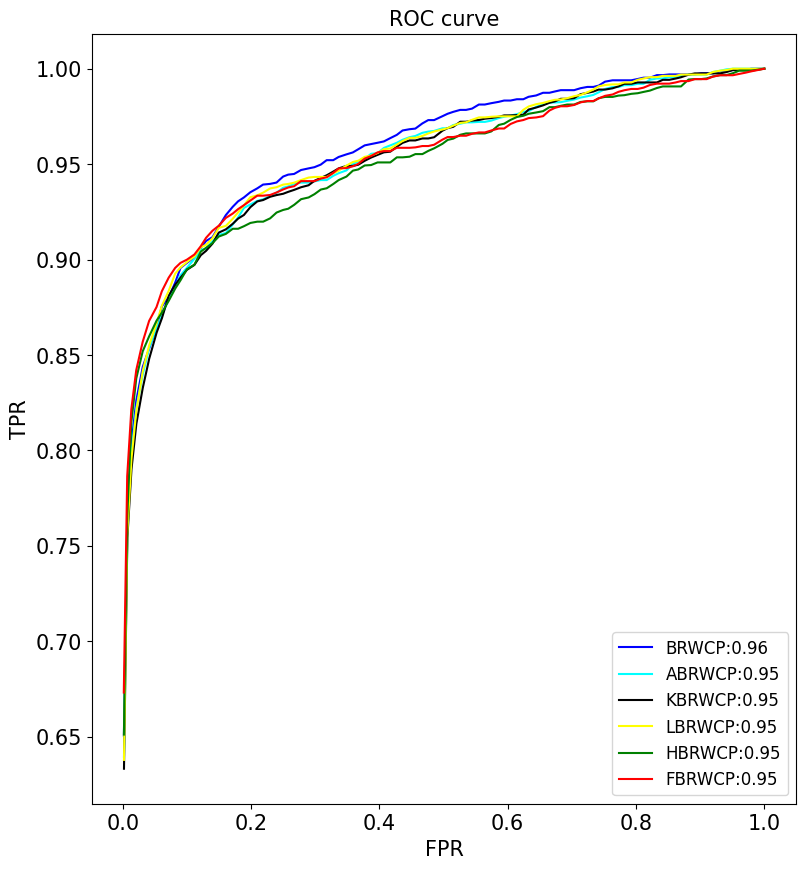

In [48]:
# %load draw_fig.py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import *
from tqdm import tqdm
import pylab as Plot

CPC_FPR = np.loadtxt('./result/fpr_list.txt')
CPC_TPR = np.loadtxt('./result/tpr_list.txt')
CPC_RECALL = np.loadtxt('./result/recall_list.txt')
CPC_P = np.loadtxt('./result/precision_list.txt')

CPC_FPR_ave = np.loadtxt('./result/fpr_list_ave.txt')
CPC_TPR_ave = np.loadtxt('./result/tpr_list_ave.txt')
CPC_RECALL_ave = np.loadtxt('./result/recall_list_ave.txt')
CPC_P_ave = np.loadtxt('./result/precision_list_ave.txt')

CPC_FPR_KA = np.loadtxt('./result/fpr_list_KA.txt')
CPC_TPR_KA = np.loadtxt('./result/tpr_list.txt_KA')
CPC_RECALL_KA = np.loadtxt('./result/recall_list_KA.txt')
CPC_P_KA = np.loadtxt('./result/precision_list_KA.txt')

CPC_FPR_hsic = np.loadtxt('./result/fpr_list_hsic.txt')
CPC_TPR_hsic = np.loadtxt('./result/tpr_list_hsic.txt')
CPC_RECALL_hsic = np.loadtxt('./result/recall_list_hsic.txt')
CPC_P_hsic = np.loadtxt('./result/precision_list_hsic.txt')

CPC_FPR_snf = np.loadtxt('./result/fpr_list_snf.txt')
CPC_TPR_snf = np.loadtxt('./result/tpr_list.txt_snf')
CPC_RECALL_snf = np.loadtxt('./result/recall_list.txt_snf')
CPC_P_snf = np.loadtxt('./result/precision_list.txt_snf')


CPC_FPR_FGS = np.loadtxt('./result/fpr_list_FGS.txt')
CPC_TPR_FGS = np.loadtxt('./result/tpr_list.txt_FGS')
CPC_RECALL_FGS = np.loadtxt('./result/recall_list.txt_FGS')
CPC_P_FGS = np.loadtxt('./result/precision_list.txt_FGS')


CPC_FPR_lic = np.loadtxt('./result/fpr_list_lic.txt')
CPC_TPR_lic = np.loadtxt('./result/tpr_list_lic.txt')
CPC_RECALL_lic = np.loadtxt('./result/recall_list_lic.txt')
CPC_P_lic = np.loadtxt('./result/precision_list_lic.txt')

plt.figure(1, figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.rcParams['figure.figsize'] = (4, 4)
plt.title('ROC curve', fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)


plt.plot(CPC_FPR, CPC_TPR, 'blue', label='BRWCP:{:.2f}'.format(auc(CPC_FPR, CPC_TPR)))
plt.plot(CPC_FPR_ave, CPC_TPR_ave, 'aqua', label='ABRWCP:{:.2f}'.format(auc(CPC_FPR_ave, CPC_TPR_ave)))
plt.plot(CPC_FPR_KA, CPC_TPR_KA, 'black', label='KBRWCP:{:.2f}'.format(auc(CPC_FPR_KA, CPC_TPR_KA)))
plt.plot(CPC_FPR_hsic, CPC_TPR_hsic, 'yellow', label='LBRWCP:{:.2f}'.format(auc(CPC_FPR_hsic, CPC_TPR_hsic)))
plt.plot(CPC_FPR_snf, CPC_TPR_snf, 'green', label='HBRWCP:{:.2f}'.format(auc(CPC_FPR_snf, CPC_TPR_snf)))
plt.plot(CPC_FPR_FGS, CPC_TPR_FGS, 'red', label='FBRWCP:{:.2f}'.format(auc(CPC_FPR_FGS, CPC_TPR_FGS)))


plt.legend(loc='lower right', fontsize=12)
# plt.plot(fpr_mean, tpr_mean)
plt.savefig('ROC curve.png')

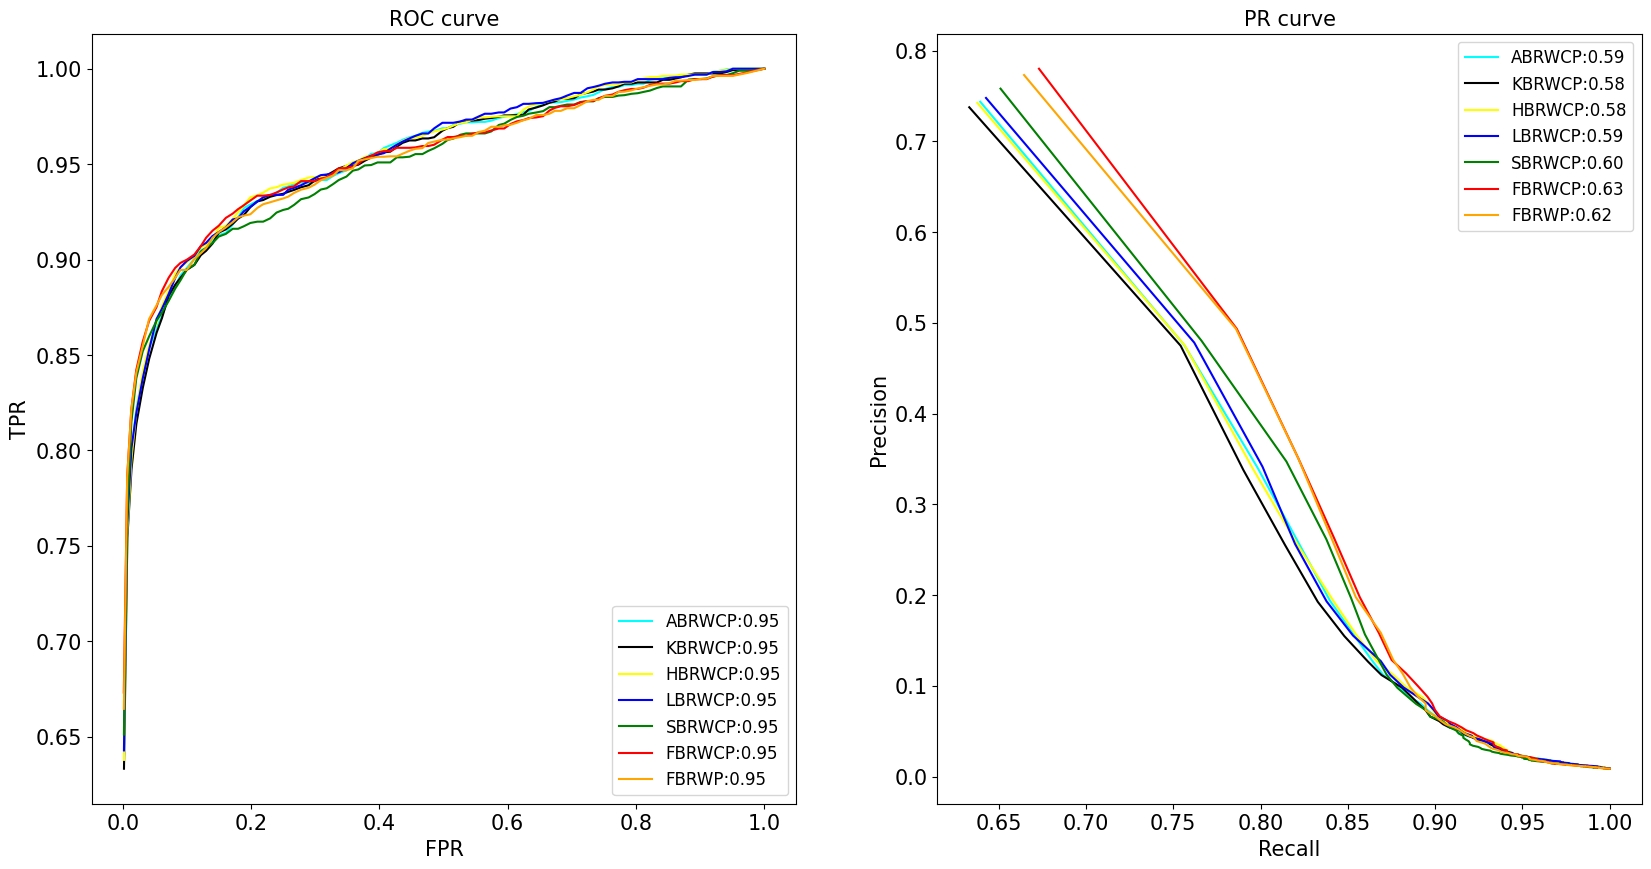

In [3]:
# %load draw_fig.py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import *
from tqdm import tqdm
import pylab as Plot

CPC_FPR = np.loadtxt('./result/fpr_list.txt')
CPC_TPR = np.loadtxt('./result/tpr_list.txt')
CPC_RECALL = np.loadtxt('./result/recall_list.txt')
CPC_P = np.loadtxt('./result/precision_list.txt')

CPC_FPR_ave = np.loadtxt('./result/fpr_list_ave.txt')
CPC_TPR_ave = np.loadtxt('./result/tpr_list_ave.txt')
CPC_RECALL_ave = np.loadtxt('./result/recall_list_ave.txt')
CPC_P_ave = np.loadtxt('./result/precision_list_ave.txt')

CPC_FPR_KA = np.loadtxt('./result/fpr_list_KA.txt')
CPC_TPR_KA = np.loadtxt('./result/tpr_list.txt_KA')
CPC_RECALL_KA = np.loadtxt('./result/recall_list_KA.txt')
CPC_P_KA = np.loadtxt('./result/precision_list_KA.txt')

CPC_FPR_hsic = np.loadtxt('./result/fpr_list_hsic.txt')
CPC_TPR_hsic = np.loadtxt('./result/tpr_list_hsic.txt')
CPC_RECALL_hsic = np.loadtxt('./result/recall_list_hsic.txt')
CPC_P_hsic = np.loadtxt('./result/precision_list_hsic.txt')

CPC_FPR_snf = np.loadtxt('./result/fpr_list_snf.txt')
CPC_TPR_snf = np.loadtxt('./result/tpr_list.txt_snf')
CPC_RECALL_snf = np.loadtxt('./result/recall_list.txt_snf')
CPC_P_snf = np.loadtxt('./result/precision_list.txt_snf')


CPC_FPR_FGS = np.loadtxt('./result/fpr_list_FGS.txt')
CPC_TPR_FGS = np.loadtxt('./result/tpr_list.txt_FGS')
CPC_RECALL_FGS = np.loadtxt('./result/recall_list.txt_FGS')
CPC_P_FGS = np.loadtxt('./result/precision_list.txt_FGS')


CPC_FPR_lic = np.loadtxt('./result/fpr_list_lic.txt')
CPC_TPR_lic = np.loadtxt('./result/tpr_list_lic.txt')
CPC_RECALL_lic = np.loadtxt('./result/recall_list_lic.txt')
CPC_P_lic = np.loadtxt('./result/precision_list_lic.txt')

CPC_FPR_FGS_2 = np.loadtxt('./result/fpr_list_FGS_2.txt')
CPC_TPR_FGS_2 = np.loadtxt('./result/tpr_list.txt_FGS_2')
CPC_RECALL_FGS_2 = np.loadtxt('./result/recall_list.txt_FGS_2')
CPC_P_FGS_2 = np.loadtxt('./result/precision_list.txt_FGS_2')


plt.figure(1, figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.rcParams['figure.figsize'] = (4, 4)
plt.title('ROC curve', fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)


#plt.plot(CPC_FPR, CPC_TPR, 'blue', label='BRWCP:{:.2f}'.format(auc(CPC_FPR, CPC_TPR)))
plt.plot(CPC_FPR_ave, CPC_TPR_ave, 'aqua', label='ABRWCP:{:.2f}'.format(auc(CPC_FPR_ave, CPC_TPR_ave)))
plt.plot(CPC_FPR_KA, CPC_TPR_KA, 'black', label='KBRWCP:{:.2f}'.format(auc(CPC_FPR_KA, CPC_TPR_KA)))
plt.plot(CPC_FPR_hsic, CPC_TPR_hsic, 'yellow', label='HBRWCP:{:.2f}'.format(auc(CPC_FPR_hsic, CPC_TPR_hsic)))
plt.plot(CPC_FPR_lic, CPC_TPR_lic, 'blue', label='LBRWCP:{:.2f}'.format(auc(CPC_FPR_lic, CPC_TPR_lic)))
plt.plot(CPC_FPR_snf, CPC_TPR_snf, 'green', label='SBRWCP:{:.2f}'.format(auc(CPC_FPR_snf, CPC_TPR_snf)))
plt.plot(CPC_FPR_FGS, CPC_TPR_FGS, 'red', label='FBRWCP:{:.2f}'.format(auc(CPC_FPR_FGS, CPC_TPR_FGS)))
plt.plot(CPC_FPR_FGS_2, CPC_TPR_FGS_2, 'orange', label='FBRWP:{:.2f}'.format(auc(CPC_FPR_FGS_2, CPC_TPR_FGS_2)))



plt.legend(loc='lower right', fontsize=12)
# plt.plot(fpr_mean, tpr_mean)
plt.savefig('ROC curve.png')

plt.subplot(1, 2, 2)
plt.title('PR curve', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Recall', fontsize=15)
plt.ylabel('Precision', fontsize=15)

#plt.plot(CPC_RECALL, CPC_P, 'blue', label='BRWCP:{:.2f}'.format(auc(CPC_RECALL, CPC_P)+CPC_RECALL[0]*CPC_P[0]))
plt.plot(CPC_RECALL_ave, CPC_P_ave, 'aqua', label='ABRWCP:{:.2f}'.format(auc(CPC_RECALL_ave, CPC_P_ave)+CPC_RECALL_ave[0]*CPC_P_ave[0]))
plt.plot(CPC_RECALL_KA, CPC_P_KA, 'black', label='KBRWCP:{:.2f}'.format(auc(CPC_RECALL_KA, CPC_P_KA)+CPC_RECALL_KA[0]*CPC_P_KA[0]))
plt.plot(CPC_RECALL_hsic, CPC_P_hsic, 'yellow', label='HBRWCP:{:.2f}'.format(auc(CPC_RECALL_hsic, CPC_P_hsic)+CPC_RECALL_hsic[0]*CPC_P_hsic[0]))
plt.plot(CPC_RECALL_lic, CPC_P_lic, 'blue', label='LBRWCP:{:.2f}'.format(auc(CPC_RECALL_lic, CPC_P_lic)+CPC_RECALL_lic[0]*CPC_P_lic[0]))
plt.plot(CPC_RECALL_snf, CPC_P_snf, 'green', label='SBRWCP:{:.2f}'.format(auc(CPC_RECALL_snf, CPC_P_snf)+CPC_RECALL_snf[0]*CPC_P_snf[0]))
plt.plot(CPC_RECALL_FGS, CPC_P_FGS, 'red', label='FBRWCP:{:.2f}'.format(auc(CPC_RECALL_FGS, CPC_P_FGS)+CPC_RECALL_FGS[0]*CPC_P_FGS[0]))
plt.plot(CPC_RECALL_FGS_2, CPC_P_FGS_2, 'orange', label='FBRWP:{:.2f}'.format(auc(CPC_RECALL_FGS_2, CPC_P_FGS_2)+CPC_RECALL_FGS_2[0]*CPC_P_FGS_2[0]))


plt.legend(loc='upper right', fontsize=12)
plt.savefig('PR curve.png')
plt.show()


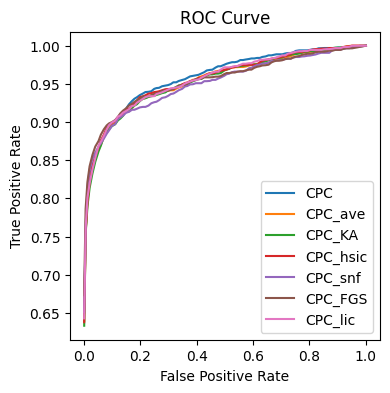

In [30]:
import matplotlib.pyplot as plt

plt.plot(CPC_FPR, CPC_TPR, label='CPC')

plt.plot(CPC_FPR_ave, CPC_TPR_ave, label='CPC_ave')

plt.plot(CPC_FPR_KA, CPC_TPR_KA, label='CPC_KA')

plt.plot(CPC_FPR_hsic, CPC_TPR_hsic, label='CPC_hsic')

plt.plot(CPC_FPR_snf, CPC_TPR_snf, label='CPC_snf')

plt.plot(CPC_FPR_FGS, CPC_TPR_FGS, label='CPC_FGS')

plt.plot(CPC_FPR_lic, CPC_TPR_lic, label='CPC_lic')

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.title('ROC Curve')

plt.legend()

plt.show()

In [ ]:
 """
        将多个机器模型的roc图输出到一张图上
        
        Args:
            names: list, 多个模型的名称
            sampling_methods: list, 多个模型的实例化对象
            save: 选择是否将结果保存（默认为png格式）
            
        Returns:
            返回图片对象plt
        """

In [24]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn import metrics
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import *
from tqdm import tqdm
import pylab as Plot

def multi_models_roc(names, sampling_methods, colors, X_test, y_test, save=True, dpin=100):
    plt.figure(figsize=(20, 20), dpi=dpin)
    for (name, method, colorname) in zip(names, sampling_methods, colors):
        y_test_preds = method.predict(X_test)
        y_test_predprob = method.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_test_predprob, pos_label=1)
        plt.plot(fpr, tpr, lw=5, label='{} (AUC={:.3f})'.format(name, auc(fpr, tpr)),color = colorname)
        plt.plot([0, 1], [0, 1], '--', lw=5, color = 'grey')
        plt.axis('square')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.xlabel('False Positive Rate',fontsize=20)
        plt.ylabel('True Positive Rate',fontsize=20)
        plt.title('ROC Curve',fontsize=25)
        plt.legend(loc='lower right',fontsize=20)

    if save:
        plt.savefig('multi_models_roc.png')
            
    return plt

In [ ]:
names = ['Logistic Regression',
         'Random Forest',
         'XGBoost',
         'AdaBoost',
         'GBDT',
         'LGBM']

sampling_methods = [clf_lr,
                    clf_rf,
                    clf_xgb,
                    clf_adb,
                    clf_gbdt,
                    clf_lgbm
                   ]

colors = ['crimson',
          'orange',
          'gold',
          'mediumseagreen',
          'steelblue', 
          'mediumpurple'  
         ]

#ROC curves
train_roc_graph = multi_models_roc(names, sampling_methods, colors, X_train, y_train, save = True)
train_roc_graph.savefig('ROC_Train_all.png')

In [ ]:
"""
    将多个机器模型的roc图输出到一张图上
    
    Args:
        names: list, 多个模型的名称
        sampling_methods: list, 多个模型的实例化对象
        save: 选择是否将结果保存（默认为png格式）
        
    Returns:
        返回图片对象plt
    """

In [ ]:
def multi_models_roc(names, sampling_methods, colors, y_label, save=True, dpin=100):
    plt.figure(figsize=(10, 10), dpi=dpin)
 
    for (name, y_pred, colorname) in zip(names, sampling_methods, colors):
        
      
        fpr, tpr, thresholds = roc_curve(y_label, y_pred, pos_label=1)
        
        plt.plot(fpr, tpr, lw=5, label='{} (AUC={:.3f})'.format(name, auc(fpr, tpr)),color = colorname)
        plt.plot([0, 1], [0, 1], '--', lw=5, color = 'grey')
        
        plt.figure(1, figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.rcParams['figure.figsize'] = (4, 4)
        plt.title('ROC curve', fontsize=15)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.xlabel('FPR', fontsize=15)
        plt.ylabel('TPR', fontsize=15)
        
        plt.axis('square')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.xlabel('False Positive Rate',fontsize=20)
        plt.ylabel('True Positive Rate',fontsize=20)
        plt.title('ROC Curve',fontsize=25)
        plt.legend(loc='lower right',fontsize=20)
 
    if save:
        plt.savefig('multi_models_roc.png')
        
    return plt

In [ ]:
names = ['UTrans_Mem',
         'Unet_Mem',
         ]
 
# sampling_methods里为 y_pred.
sampling_methods = [preds_UT_mem,
                    preds_U_mem,
                   ]
#color:'crimson','orange','gold','mediumseagreen','steelblue', 'mediumpurple' 
colors = ['crimson',
          'orange',
         ]
 
#ROC curves
train_roc_graph = multi_models_roc(names, sampling_methods, colors, label[0], save = True)
train_roc_graph.savefig('ROC_Train_all.png')

In [26]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))

plt.plot(CPC_FPR, CPC_TPR, label='CPC')

plt.plot(CPCFPRave, CPCTPRave, label='CPC_AVE')

plt.plot(CPCFPRKA, CPCTPRKA, label='CPC_KA')

plt.plot(CPCFPRhsic, CPCTPRhsic, label='CPC_HSIC')

plt.plot(CPCFPRsnf, CPCTPRsnf, label='CPC_SNF')

plt.plot(CPCFPRFGS, CPCTPRFGS, label='CPC_FGS')

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.title('ROC Curve')

plt.legend()

Plot Precision-Recall curves
plt.figure(figsize=(10, 5))

plt.plot(CPCRECALL, CPCP, label='CPC')

plt.plot(CPCRECALLave, CPCPave, label='CPC_AVE')

plt.plot(CPCRECALLKA, CPCPKA, label='CPC_KA')

plt.plot(CPCRECALLhsic, CPCPhsic, label='CPC_HSIC')

plt.plot(CPCRECALLsnf, CPCPsnf, label='CPC_SNF')

plt.plot(CPCRECALLFGS, CPCPFGS, label='CPC_FGS')

plt.xlabel('Recall')

plt.ylabel('Precision')

plt.title('Precision-Recall Curve')

plt.legend()

plt.show()

SyntaxError: invalid syntax (3020642866.py, line 26)

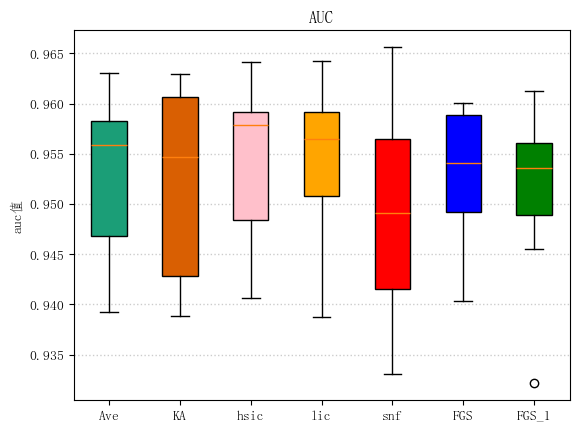

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mpl.rcParams["font.sans-serif"]=["FangSong"]
mpl.rcParams["axes.unicode_minus"]=False

#testA = np.random.randn(5000)
#testB = np.random.randn(5000)
Ave_BRWPC_auc =np.array([0.9630416842011534,0.9595349065898146,0.9567635421026012,0.9550237241489945,0.95237049776473,0.944974644342727,0.9392044816103087,0.9574590035447782,0.9585432291361086,0.9417340645943751])
Ave_BRWPC_aupr= np.array([0.6125996841429198,0.598377834445378,0.5400002035097997,0.5606549259921789,0.6389742385656964,0.5286344307553269,0.5604342691070668,0.6031145836546494,0.6292687495717,0.5843733888449222])

KA_BRWPC_auc =np.array([0.9629509375352208,0.9616197938801019,0.9577696575255323,0.9621286333536248,0.9479656695757201,0.9396036385146945,0.9411615989629211,0.956215965122639,0.9532174473773276,0.9388471456846911])
KA_BRWPC_aupr= np.array([0.618105801710723,0.6014292672406503,0.5296951186212839,0.5549861272888488,0.6006662645807576,0.5294749083556437,0.5655620502448002,0.5720030368113298,0.6113715238042591,0.5927841561045167])

hsic_BRWPC_auc =np.array([0.9641589777211005,0.9576675564238686,0.9581032972967493,0.9595124604306525,0.9579944212047317,0.9453794582238091,0.9406901815036784,0.95744305694921,0.9596626504477117,0.9406812300811292])
hsic_BRWPC_aupr= np.array([0.6194849541670802,0.5976840095934248,0.538414798526832,0.5478705737826441,0.6112176970747916,0.5298043868784287,0.5551273389956016,0.5914832032097663,0.6597783862242237,0.5970190957366903])

lic_BRWPC_auc =np.array([0.9642456649372056,0.9575211467900755,0.9563344605367828,0.9601294476904191,0.95420121732128,0.9496571690575155,0.9387535716983054,0.9566195075040484,0.9597442740744822,0.9429968631891689])
lic_BRWPC_aupr= np.array([0.6234131112243256,0.6180434997018774,0.5502494683667344,0.5564751531242573,0.6084537019513503,0.5208828013784935,0.5527209342239973,0.6074227531145387,0.6767710725069087,0.5965646094445931])

snf_BRWPC_auc =np.array([0.9582071728601507,0.95028499477225,0.9480314631712838,0.9511200407809877,0.965648940359202,0.9393204614515699,0.9330602745695332,0.9613686646920393,0.9413449308990676,0.9421971355976074])
snf_BRWPC_aupr= np.array([0.6144358820977623,0.6292183379246294,0.5692455914362284,0.5969857571212049,0.6697335895306947,0.509041707316138,0.5619666104492969,0.6326760752302273,0.6275694515513157,0.6277054621041468])

FGS_BRWPC_auc =np.array([0.960035531459118,0.956024801202503,0.9521391910168181,0.9505547143590296,0.9589480022987001,0.9586002137141645,0.9403231083539817,0.9591870827193429,0.948704704393003,0.9436110768460416])
FGS_BRWPC_aupr= np.array([0.6491631771884554,0.6479879177959631,0.6210504536916298,0.611767450359191,0.6701557417383919,0.5655323316607698,0.6022244880037834,0.6257981968013027,0.6657951925403681,0.6468627173207684])

FGS_BRWP_auc = np.array([0.9566033972016801,0.955288701717421,0.956069784322959,0.9519655663206281,0.9612326984268454,0.9454755532246203,0.9321793706414995,0.9560602738268215,0.948639628255221,0.9496775904121577])
FGS_BRWP_aupr = np.array([0.6332092224598472,0.6243094931963986,0.6433168051836502,0.5926205924467935,0.6629003560259957,0.5489486887665095,0.6415799416027398,0.5866625370242443,0.6374235426521111,0.6688821717267378])


testList = [Ave_BRWPC_auc,KA_BRWPC_auc,hsic_BRWPC_auc,lic_BRWPC_auc,snf_BRWPC_auc,FGS_BRWPC_auc,FGS_BRWP_auc]
labels = ["Ave","KA","hsic","lic","snf","FGS","FGS_1"]
colors = ["#1b9e77","#d95f02","pink","orange","red","blue","green"]

whis = 1.6
width = 0.5

bplot = plt.boxplot(testList,
                    whis=whis,
                    widths=width,
                    sym="o",
                    labels=labels,
                    patch_artist=True)

for patch,color in zip(bplot["boxes"],colors):
    patch.set_facecolor(color)

plt.ylabel("auc值")
plt.title('AUC')

plt.grid(axis="y",ls=":",lw=1,color="gray",alpha=0.4)

plt.savefig('AUC.png')
plt.show()


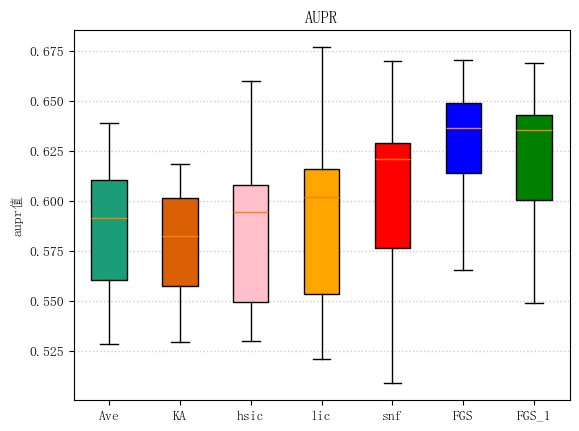

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mpl.rcParams["font.sans-serif"]=["FangSong"]
mpl.rcParams["axes.unicode_minus"]=False

#testA = np.random.randn(5000)
#testB = np.random.randn(5000)
Ave_BRWPC_auc =np.array([0.9630416842011534,0.9595349065898146,0.9567635421026012,0.9550237241489945,0.95237049776473,0.944974644342727,0.9392044816103087,0.9574590035447782,0.9585432291361086,0.9417340645943751])
Ave_BRWPC_aupr= np.array([0.6125996841429198,0.598377834445378,0.5400002035097997,0.5606549259921789,0.6389742385656964,0.5286344307553269,0.5604342691070668,0.6031145836546494,0.6292687495717,0.5843733888449222])

KA_BRWPC_auc =np.array([0.9629509375352208,0.9616197938801019,0.9577696575255323,0.9621286333536248,0.9479656695757201,0.9396036385146945,0.9411615989629211,0.956215965122639,0.9532174473773276,0.9388471456846911])
KA_BRWPC_aupr= np.array([0.618105801710723,0.6014292672406503,0.5296951186212839,0.5549861272888488,0.6006662645807576,0.5294749083556437,0.5655620502448002,0.5720030368113298,0.6113715238042591,0.5927841561045167])

hsic_BRWPC_auc =np.array([0.9641589777211005,0.9576675564238686,0.9581032972967493,0.9595124604306525,0.9579944212047317,0.9453794582238091,0.9406901815036784,0.95744305694921,0.9596626504477117,0.9406812300811292])
hsic_BRWPC_aupr= np.array([0.6194849541670802,0.5976840095934248,0.538414798526832,0.5478705737826441,0.6112176970747916,0.5298043868784287,0.5551273389956016,0.5914832032097663,0.6597783862242237,0.5970190957366903])

lic_BRWPC_auc =np.array([0.9642456649372056,0.9575211467900755,0.9563344605367828,0.9601294476904191,0.95420121732128,0.9496571690575155,0.9387535716983054,0.9566195075040484,0.9597442740744822,0.9429968631891689])
lic_BRWPC_aupr= np.array([0.6234131112243256,0.6180434997018774,0.5502494683667344,0.5564751531242573,0.6084537019513503,0.5208828013784935,0.5527209342239973,0.6074227531145387,0.6767710725069087,0.5965646094445931])

snf_BRWPC_auc =np.array([0.9582071728601507,0.95028499477225,0.9480314631712838,0.9511200407809877,0.965648940359202,0.9393204614515699,0.9330602745695332,0.9613686646920393,0.9413449308990676,0.9421971355976074])
snf_BRWPC_aupr= np.array([0.6144358820977623,0.6292183379246294,0.5692455914362284,0.5969857571212049,0.6697335895306947,0.509041707316138,0.5619666104492969,0.6326760752302273,0.6275694515513157,0.6277054621041468])

FGS_BRWPC_auc =np.array([0.960035531459118,0.956024801202503,0.9521391910168181,0.9505547143590296,0.9589480022987001,0.9586002137141645,0.9403231083539817,0.9591870827193429,0.948704704393003,0.9436110768460416])
FGS_BRWPC_aupr= np.array([0.6491631771884554,0.6479879177959631,0.6210504536916298,0.611767450359191,0.6701557417383919,0.5655323316607698,0.6022244880037834,0.6257981968013027,0.6657951925403681,0.6468627173207684])

FGS_BRWP_auc = np.array([0.9566033972016801,0.955288701717421,0.956069784322959,0.9519655663206281,0.9612326984268454,0.9454755532246203,0.9321793706414995,0.9560602738268215,0.948639628255221,0.9496775904121577])
FGS_BRWP_aupr = np.array([0.6332092224598472,0.6243094931963986,0.6433168051836502,0.5926205924467935,0.6629003560259957,0.5489486887665095,0.6415799416027398,0.5866625370242443,0.6374235426521111,0.6688821717267378])
testList = [Ave_BRWPC_aupr,KA_BRWPC_aupr,hsic_BRWPC_aupr,lic_BRWPC_aupr,snf_BRWPC_aupr,FGS_BRWPC_aupr,FGS_BRWP_aupr]
labels = ["Ave","KA","hsic","lic","snf","FGS","FGS_1"]
colors = ["#1b9e77","#d95f02","pink","orange","red","blue","green"]

whis = 1.6
width = 0.5

bplot = plt.boxplot(testList,
                    whis=whis,
                    widths=width,
                    sym="o",
                    labels=labels,
                    patch_artist=True)

for patch,color in zip(bplot["boxes"],colors):
    patch.set_facecolor(color)

plt.ylabel("aupr值")
plt.title("AUPR")

plt.grid(axis="y",ls=":",lw=1,color="gray",alpha=0.4)

plt.savefig('AUPR.png')
plt.show()


# 消融实验

In [ ]:
# %load run_main.py
import numpy as np
from function import *
from tqdm import trange
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.metrics
import copy
rs = 0.6
n_fold=10
eta=0.7
l_1=5
l_2=5
fr=500
fp=300
K=20
#dr_dis=np.loadtxt("./source_data/luo_simmat_drugs_disease.txt")
dr_pre=np.loadtxt("./source_data/mat_drug_protein.txt")
#pre_dis=np.loadtxt("./source_data/luo_simmat_proteins_disease.txt")
#dr_dr=np.loadtxt("./source_data/luo_simmat_drugs_ddi.txt")
#dr_se=np.loadtxt("./source_data/luo_simmat_drugs_se.txt")
#pre_pre=np.loadtxt("./source_data/luo_simmat_proteins_ppi.txt")
#pre_pre_sw=np.loadtxt("./source_data/luo_simmat_proteins_sw-n.txt")
simdr=np.loadtxt("./source_data/Similarity_Matrix_Drugs.txt")
simpre=np.loadtxt("./source_data/Similarity_Matrix_Proteins.txt")

drnum=len(simdr)     #药物的数目
#disnum=len(dr_dis[0])     #副作用的数目
prenum=len(simpre)     #蛋白质的数目


index_1 = np.loadtxt("./dataset/index_1.txt")
index_0 = np.loadtxt("./dataset/index_0.txt")
index = np.hstack((index_1, index_0))     #水平拼接
reala=dr_pre
sr = simdr
sd = simpre/100

RR=np.zeros(dr_pre.shape)       #原始的邻接矩阵
#A = np.hstack((dr_dr, dr_dis, dr_se))       #Fr
#B = np.hstack((pre_pre, pre_dis))         #Fp
#cutdr_dis = SVD(A, fr)    #奇异值分解    Fr'
#cutpre_dis = SVD(B, fp)     #奇异值分解    Fp'
#pre_simdti = cosine_similarity(cutpre_dis, cutpre_dis)    #计算余弦相似度   SrF
#dr_simdti = cosine_similarity(cutdr_dis, cutdr_dis)        #计算余弦相似度   SpF
pre_simdti = np.loadtxt("./source_data/S_FGS_p.txt")
dr_simdti = np.loadtxt("./source_data/S_FGS_d.txt")


srfp, spfp = pruning(K=K, drug_mat=dr_simdti, target_mat=pre_simdti, miu=eta)
srsp, spsp = pruning(K=K, drug_mat=sr, target_mat=sd, miu=eta)

for f in trange(n_fold):
    a = np.loadtxt("./dataset/DTI" + str(f) + ".txt")
    idx=index[f,:]
   
    R = copy.deepcopy(a)
    R = BiRW(R, dr_simdti, pre_simdti, a, rs)        
    for i in trange(l_1):
        R=BiRW(R, srfp, spfp, a, rs/2)
    for i in trange(l_2):
        R=BiRW(R, srsp, spsp, a, rs/2)

    realvalue=np.zeros(R.shape)
    #for i in range(len(idx)):
        #d=int(idx[i]/prenum)
        #p=int(idx[i]%prenum)
        #realvalue[d,p]=reala[d,p]
    #for i in range(len(idx)):
        #d=int(idx[i]/prenum)
        #p=int(idx[i]%prenum)
        #RR[d,p]=R[d,p]

y_true_m = dr_pre.tolist()
y_pre_m = R.tolist()

tpr_cov=[[] for i in range(n_fold)]
fpr_cov=[[] for i in range(n_fold)]
recall_cov=[[] for i in range(n_fold)]
precision_cov=[[] for i in range(n_fold)]

for f in range(n_fold):
    idx=index[f,:]
    singal=[[] for i in range(len(y_true_m))]
    singal_test=[[] for i in range(len(y_true_m))]
    for i in trange(len(y_true_m)):
        for j in range(len(y_true_m[0])):
            if i*prenum+j in idx:
                singal[i].append(y_true_m[i][j])
                singal_test[i].append(y_pre_m[i][j])
    y_true=singal
    y_pre=singal_test

    idx = []
    tpr_list = []
    fpr_list = []
    recall_list = []
    precision_list = []
    c = 0
    for i in trange(len(y_true)):
        if np.sum(np.array(y_true[i])) == 0:
            c += 1
            continue
        else:
            tpr1, fpr1, precision1, recall1 = tpr_fpr_precision_recall(np.array(y_true[i]), np.array(y_pre[i]))
            fpr_list.append(fpr1)
            tpr_list.append(tpr1)
            precision_list.append(precision1)
            recall_list.append(recall1)
    coverage = []

    for i in tpr_list:
        try:
            coverage.append(i.index(1.0)+1)
        except:
            print('1')
    print(np.mean(np.array(coverage)))

    tpr = equal_len_list(tpr_list)
    print(len(tpr ),type(tpr))
    fpr = equal_len_list(fpr_list)
    precision = equal_len_list(precision_list)
    recall = equal_len_list(recall_list)
    tpr_mean = np.mean(tpr, axis=0)
    tpr_cov[f]=tpr_mean
    print(type(tpr_mean),len(tpr_mean))
    fpr_mean = np.mean(fpr, axis=0)
    fpr_cov[f]=fpr_mean
    recall_mean = np.mean(recall, axis=0)
    recall_cov[f]=recall_mean
    precision_mean = np.mean(precision, axis=0)
    precision_cov[f]=precision_mean
    print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean, tpr_mean))
    print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean, precision_mean)+recall_mean[0]*precision_mean[0])

tpr = equal_len_list(tpr_cov)
fpr = equal_len_list(fpr_cov)
precision = equal_len_list(precision_cov)
recall = equal_len_list(recall_cov)

tpr_mean_FGS_1 = np.mean(tpr, axis=0)
fpr_mean_FGS_1 = np.mean(fpr, axis=0)
recall_mean_FGS_1 = np.mean(recall, axis=0)
precision_mean_FGS_1 = np.mean(precision, axis=0)

print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean_FGS_1, tpr_mean_FGS_1))
print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean_FGS_1, precision_mean_FGS_1)+recall_mean_FGS_1[0]*precision_mean_FGS_1[0])

np.savetxt('./result/fpr_list_FGS_1.txt', fpr_mean_FGS_1)
np.savetxt('./result/tpr_list.txt_FGS_1', tpr_mean_FGS_1)
np.savetxt('./result/recall_list.txt_FGS_1', recall_mean_FGS_1)
np.savetxt('./result/precision_list.txt_FGS_1', precision_mean_FGS_1)






 48%|██████████████████████████████████████▊                                         | 343/708 [00:10<00:10, 34.12it/s]

In [ ]:
import time
# 记录开始时间
start_time = time.time()
# 计算灵敏度
sensitivity = tpr_mean_ave  # 由于tpr_mean_ave已经是真正率，这里直接使用

# 记录结束时间并计算运行时间
end_time = time.time()
runtime = end_time - start_time
# 打印灵敏度和运行时间

print('Runtime:', runtime)

# FBRWP

In [7]:
# %load run_main.py
import numpy as np
from function import *
from tqdm import trange
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.metrics
import copy
import time
rs = 0.6
n_fold=10
eta=0.7
l_1=5
l_2=5
fr=500
fp=300
K=20
#dr_dis=np.loadtxt("./source_data/luo_simmat_drugs_disease.txt")
dr_pre=np.loadtxt("./source_data/mat_drug_protein.txt")
#pre_dis=np.loadtxt("./source_data/luo_simmat_proteins_disease.txt")
#dr_dr=np.loadtxt("./source_data/luo_simmat_drugs_ddi.txt")
#dr_se=np.loadtxt("./source_data/luo_simmat_drugs_se.txt")
#pre_pre=np.loadtxt("./source_data/luo_simmat_proteins_ppi.txt")
#pre_pre_sw=np.loadtxt("./source_data/luo_simmat_proteins_sw-n.txt")
simdr=np.loadtxt("./source_data/Similarity_Matrix_Drugs.txt")
simpre=np.loadtxt("./source_data/Similarity_Matrix_Proteins.txt")

drnum=len(simdr)     #药物的数目
#disnum=len(dr_dis[0])     #副作用的数目
prenum=len(simpre)     #蛋白质的数目


index_1 = np.loadtxt("./dataset/index_1.txt")
index_0 = np.loadtxt("./dataset/index_0.txt")
index = np.hstack((index_1, index_0))     #水平拼接
reala=dr_pre
sr = simdr
sd = simpre/100

RR=np.zeros(dr_pre.shape)       #原始的邻接矩阵
#A = np.hstack((dr_dr, dr_dis, dr_se))       #Fr
#B = np.hstack((pre_pre, pre_dis))         #Fp
#cutdr_dis = SVD(A, fr)    #奇异值分解    Fr'
#cutpre_dis = SVD(B, fp)     #奇异值分解    Fp'
#pre_simdti = cosine_similarity(cutpre_dis, cutpre_dis)    #计算余弦相似度   SrF
#dr_simdti = cosine_similarity(cutdr_dis, cutdr_dis)        #计算余弦相似度   SpF
pre_simdti = np.loadtxt("./source_data/S_FGS_p.txt")
dr_simdti = np.loadtxt("./source_data/S_FGS_d.txt")

# 记录开始时间
start_time = time.time()

srfp, spfp = pruning(K=K, drug_mat=dr_simdti, target_mat=pre_simdti, miu=eta)
srsp, spsp = pruning(K=K, drug_mat=sr, target_mat=sd, miu=eta)

for f in trange(n_fold):
    a = np.loadtxt("./dataset/DTI" + str(f) + ".txt")
    idx=index[f,:]
   
    R = copy.deepcopy(a)
    R = BiRW(R, dr_simdti, pre_simdti, a, rs)        
    for i in trange(l_1):
        R=BiRW(R, srfp, spfp, a, rs/2)
    #for i in trange(l_2):
        #R=BiRW(R, srsp, spsp, a, rs/2)

    realvalue=np.zeros(R.shape)
    for i in range(len(idx)):
        d=int(idx[i]/prenum)
        p=int(idx[i]%prenum)
        realvalue[d,p]=reala[d,p]
    for i in range(len(idx)):
        d=int(idx[i]/prenum)
        p=int(idx[i]%prenum)
        RR[d,p]=R[d,p]

y_true_m = dr_pre.tolist()
y_pre_m = RR.tolist()

tpr_cov=[[] for i in range(n_fold)]
fpr_cov=[[] for i in range(n_fold)]
recall_cov=[[] for i in range(n_fold)]
precision_cov=[[] for i in range(n_fold)]

for f in range(n_fold):
    idx=index[f,:]
    singal=[[] for i in range(len(y_true_m))]
    singal_test=[[] for i in range(len(y_true_m))]
    for i in trange(len(y_true_m)):
        for j in range(len(y_true_m[0])):
            if i*prenum+j in idx:
                singal[i].append(y_true_m[i][j])
                singal_test[i].append(y_pre_m[i][j])
    y_true=singal
    y_pre=singal_test

    idx = []
    tpr_list = []
    fpr_list = []
    recall_list = []
    precision_list = []
    c = 0
    for i in trange(len(y_true)):
        if np.sum(np.array(y_true[i])) == 0:
            c += 1
            continue
        else:
            tpr1, fpr1, precision1, recall1 = tpr_fpr_precision_recall(np.array(y_true[i]), np.array(y_pre[i]))
            fpr_list.append(fpr1)
            tpr_list.append(tpr1)
            precision_list.append(precision1)
            recall_list.append(recall1)
    coverage = []

    for i in tpr_list:
        try:
            coverage.append(i.index(1.0)+1)
        except:
            print('1')
    print(np.mean(np.array(coverage)))

    tpr = equal_len_list(tpr_list)
    print(len(tpr ),type(tpr))
    fpr = equal_len_list(fpr_list)
    precision = equal_len_list(precision_list)
    recall = equal_len_list(recall_list)
    tpr_mean = np.mean(tpr, axis=0)
    tpr_cov[f]=tpr_mean
    print(type(tpr_mean),len(tpr_mean))
    fpr_mean = np.mean(fpr, axis=0)
    fpr_cov[f]=fpr_mean
    recall_mean = np.mean(recall, axis=0)
    recall_cov[f]=recall_mean
    precision_mean = np.mean(precision, axis=0)
    precision_cov[f]=precision_mean
    print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean, tpr_mean))
    print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean, precision_mean)+recall_mean[0]*precision_mean[0])

tpr = equal_len_list(tpr_cov)
fpr = equal_len_list(fpr_cov)
precision = equal_len_list(precision_cov)
recall = equal_len_list(recall_cov)

tpr_mean_FGS_2 = np.mean(tpr, axis=0)
fpr_mean_FGS_2 = np.mean(fpr, axis=0)
recall_mean_FGS_2 = np.mean(recall, axis=0)
precision_mean_FGS_2 = np.mean(precision, axis=0)
# 记录结束时间并计算运行时间
end_time = time.time()
runtime = end_time - start_time
print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean_FGS_2, tpr_mean_FGS_2))
print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean_FGS_2, precision_mean_FGS_2)+recall_mean_FGS_2[0]*precision_mean_FGS_2[0])
# 打印灵敏度和运行时间

print('Runtime:', runtime)
#np.savetxt('./result/fpr_list_FGS_2.txt', fpr_mean_FGS_2)
#np.savetxt('./result/tpr_list.txt_FGS_2', tpr_mean_FGS_2)
#np.savetxt('./result/recall_list.txt_FGS_2', recall_mean_FGS_2)
#np.savetxt('./result/precision_list.txt_FGS_2', precision_mean_FGS_2)






100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1749.62it/s]


8.56
150 <class 'list'>
<class 'numpy.ndarray'> 131
The auc of prediction is: 0.9566033972016801
The aupr of prediction is: 0.6332092224598472


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1872.12it/s]


8.315068493150685
146 <class 'list'>
<class 'numpy.ndarray'> 116
The auc of prediction is: 0.955288701717421
The aupr of prediction is: 0.6243094931963986


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1908.17it/s]


8.575949367088608
158 <class 'list'>
<class 'numpy.ndarray'> 102
The auc of prediction is: 0.956069784322959
The aupr of prediction is: 0.6433168051836502


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1904.29it/s]


8.70748299319728
147 <class 'list'>
<class 'numpy.ndarray'> 119
The auc of prediction is: 0.9519655663206281
The aupr of prediction is: 0.5926205924467935


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1834.43it/s]


8.43661971830986
142 <class 'list'>
<class 'numpy.ndarray'> 119
The auc of prediction is: 0.9612326984268454
The aupr of prediction is: 0.6629003560259957


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1935.70it/s]


10.782894736842104
152 <class 'list'>
<class 'numpy.ndarray'> 120
The auc of prediction is: 0.9454755532246203
The aupr of prediction is: 0.5489486887665095


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1892.48it/s]


12.204081632653061
147 <class 'list'>
<class 'numpy.ndarray'> 126
The auc of prediction is: 0.9321793706414995
The aupr of prediction is: 0.6415799416027398


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1795.91it/s]


8.70945945945946
148 <class 'list'>
<class 'numpy.ndarray'> 128
The auc of prediction is: 0.9560602738268215
The aupr of prediction is: 0.5866625370242443


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2184.49it/s]


9.492957746478874
142 <class 'list'>
<class 'numpy.ndarray'> 127
The auc of prediction is: 0.948639628255221
The aupr of prediction is: 0.6374235426521111


100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 1921.31it/s]


9.076923076923077
143 <class 'list'>
<class 'numpy.ndarray'> 122
The auc of prediction is: 0.9496775904121577
The aupr of prediction is: 0.6688821717267378
The auc of prediction is: 0.9513576895156638
The aupr of prediction is: 0.6233045451594007
Runtime: 356.5188820362091


In [ ]:
[0.9566033972016801,0.955288701717421,0.956069784322959,0.9519655663206281,0.9612326984268454,0.9454755532246203,0.9321793706414995,0.9560602738268215,0.948639628255221,0.9496775904121577]
[0.6332092224598472,0.6243094931963986,0.6433168051836502,0.5926205924467935,0.6629003560259957,0.5489486887665095,0.6415799416027398,0.5866625370242443,0.6374235426521111,0.6688821717267378]

# 性能比较条形图

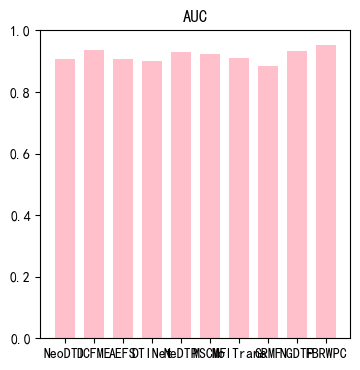

In [16]:
import matplotlib.pyplot as plt

# 这两行代码解决 plt 中文显示的问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

models = ('NeoDTI', 'DCFME', 'AEFS', 'DTINet', 'NeDTP','MSCMF','MolTrans','GRMF','NGDTP','FBRWPC')
auc = [0.908, 0.936, 0.906, 0.902, 0.929,0.922,0.910,0.885,0.933,0.953]
aupr = [0.508,0.596,0.477,0.311,0.080,0.599,0.102,0.473,0.324,0.630]
bar_width = 0.7 # 条形宽度

plt.bar(models , auc,width=bar_width, color='pink', label='AUC')
plt.title('AUC')

plt.show()

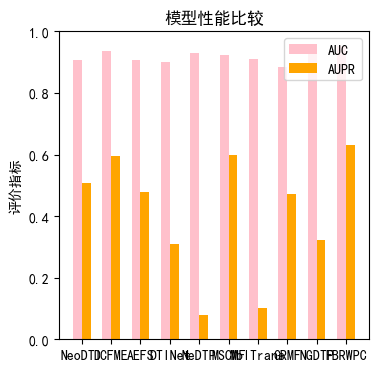

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# 这两行代码解决 plt 中文显示的问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 输入统计数据
models = ('NeoDTI', 'DCFME', 'AEFS', 'DTINet', 'NeDTP','MSCMF','MolTrans','GRMF','NGDTP','FBRWPC')
auc = [0.908, 0.936, 0.906, 0.902, 0.929,0.922,0.910,0.885,0.933,0.953]
aupr = [0.508,0.596,0.477,0.311,0.080,0.599,0.102,0.473,0.324,0.630]

bar_width = 0.3  # 条形宽度
index_auc = np.arange(len(models))  # 男生条形图的横坐标
index_aupr = index_auc + bar_width  # 女生条形图的横坐标

# 使用两次 bar 函数画出两组条形图
plt.bar(index_auc, height=auc, width=bar_width, color='pink', label='AUC')
plt.bar(index_aupr, height=aupr, width=bar_width, color='orange', label='AUPR')

plt.legend()  # 显示图例
plt.xticks(index_auc + bar_width/2, models)  # 让横坐标轴刻度显示 waters 里的饮用水， index_male + bar_width/2 为横坐标轴刻度的位置
plt.ylabel('评价指标')  # 纵坐标轴标题
plt.title('模型性能比较')  # 图形标题

plt.show()

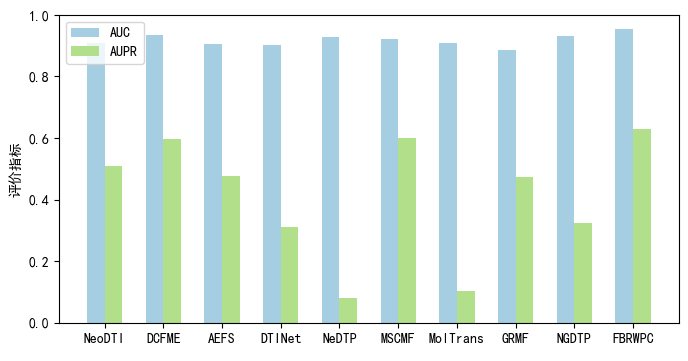

In [21]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import palettable
import pandas as pd
plt.rcParams['axes.unicode_minus']=False # 解决负号不显示问题
mpl.rcParams["font.sans-serif"] = ["SimHei"]  #正常显示中文标签
plt.figure(figsize=(8,4))
n=10
t_l = ('NeoDTI', 'DCFME', 'AEFS', 'DTINet', 'NeDTP','MSCMF','MolTrans','GRMF','NGDTP','FBRWPC')
width = 0.3
x=np.arange(n)+1
auc = [0.908, 0.936, 0.906, 0.902, 0.929,0.922,0.910,0.885,0.933,0.953]
aupr = [0.508,0.596,0.477,0.311,0.080,0.599,0.102,0.473,0.324,0.630]
 
plt.bar(x,auc, width, align="center", color=palettable.colorbrewer.qualitative.Paired_4.mpl_colors[0], label="AUC", alpha=1)
plt.bar(x+width, aupr, width, align="center",color=palettable.colorbrewer.qualitative.Paired_4.mpl_colors[2], label="AUPR", alpha=1)
 
plt.xlabel(' ', fontdict={'weight':'normal','size':0.1}, labelpad=None, loc='right')   #x轴名称,labelpad设置轴名称离x轴的距离
plt.ylabel('评价指标', fontsize=10)   #y轴名称
plt.xticks(x+width/2, t_l)  #底部汉字移动到两个柱状条中间
plt.legend()  #表示不同图形的文本标签图案
plt.legend(loc="upper left")
plt.show()